## HW 4 - Supervised Learning at Scale.
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2023`__

> Updated: 06/18/2023

HW4 is composed of two sections (see module 6 for access to the HW4 sections):

* Section 1: A timed quiz (20 questions) with all questions available in Digital Campus only. You will need a Spark cluster to complete the questions. You will get three attempts to complete this quiz and you will get some feedback after each attempt. 
* Section 2: A regular assignment in the form of a Jupyter notebook and Digital Campus quiz with no immediate feedback upon submission. 
NOTE: both parts will be graded and will contribute to your overall grade for the semester.

This notebook and corresponding Digital Campus quiz forms part 2 of 2 for HW4.

In the first three HW assignment, you became familiar with the Map-Reduce programming paradigm as manifested in the Hadoop Streaming and Spark frameworks. We explored how different data structures and design patterns can help us manage the computational complexity of an algorithm. As part of this process you implemented both a supervised learning alogorithm (Naive Bayes) and an unsupervised learning algorithm (synonym detection via cosine similarity). In both of these tasks parallelization helped us manage calculations involving a large number of features. However a large feature space isn't the only situation that might prompt us to want to parallelize a machine learning algorithm. In the final two assignments we'll look at cases where the iterative nature of an algorithm is the main driver of its computational complexity (and the reason we might want to parallelize it).

In this assignment, you will perform learn linear models using different loss functions: OLS, RidgeMSE, LassoMSE, BXE, CXE, RidgeBXE, LASSOBXE, etc.. As in previous assignments, you will implement the core calculations using Spark RDDs, and you will also start working with Spark DataFrames. Though we've provided more of a code base than before since the focus of the latter half of the course is more on general machine learning concepts. By the end of this homework you should be able to:

* ... __define__ the loss functions for linear regression and linear classifier models: OLS MSE, RidgeMSE, LassoMSE, BXE, CXE, RidgeBXE, LASSOBXE, etc. 
* ... __calculate__ the gradient for each of these loss functions.
* ... __identify__ which parts of the gradient descent algorithm can be parallelized.
* ... __implement__ parallelized gradient descent with cross-validation and regularization.
* ... __compare/contrast__ how L1 and L2 regularization impact model parameters & performance.

Additional Reference: [latest (3.2.0) Spark Documentation - RDD programming guide](https://spark.apache.org/docs/3.2.0/rdd-programming-guide.html)

__Please refer to the `README` for homework submission instructions and additional resources.__

## Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

### Data and HW output vs notebook Locations: private data bucket versus dataproc staging bucket

When you create a DataProc cluster, HDFS is used as the default filesystem. In this course, we override this behavior by setting the defaultFS as a Cloud Storage bucket. The benefits of using Cloud Storage buckets are that your job results get to persist beyond the lifetime of the cluster (and btw latency on these cloud buckets is super low).

In this HW, you use your personal cloud bucket (and folders on them), known as DATA_BUCKET, as:
* input and output for the Spark Apps that you will develop as part of your submission.  
* you will save your jupyter notebooks and data on your personal cloud bucket also!

The datasets for this homework will be downloaded and saved into your `private Data Bucket` on Google Cloud. Recall that you created a private data bucket during the first week of semester. You may have called it w261-<your initials>. Jimi's bucket name is `w261-jgs`. To facilitate ease of access, we have set up location variables for the course-related data buckets. Your private data bucket  can be accessed via: 

* ```python
    import os
    DATA_BUCKET = os.getenv('DATA_BUCKET','')[:-1] # our private storage bucket location
```

This DATA_BUCKET will be used for hosting the input data for this assignment and also to store output from your HW Assignment apps.
Associated with each DataProc cluster is a persistant storage bucket that we refer to as the DataProc Staging Bucket. You will be using this staging bucket to store notebooks and other files associated with your HW assignments, and  live sessions. The location of the staging bucket  is made available via `os.getenv("STAGING_BUCKET")`. Since this bucket is persistent, we will no longer need to snapshot your student workspaces. 
    
For more background on Dataproc staging  buckets please see:
* [https://cloud.google.com/dataproc/docs/concepts/configuring-clusters/staging-bucket](https://cloud.google.com/dataproc/docs/concepts/configuring-clusters/staging-bucket)

In [2]:
# Access your personal data bucket and see whats there (RUN THIS CELL AS IS)
import os
DATA_BUCKET = os.getenv('DATA_BUCKET','')[:-1] # our private storage bucket location
HW4_FOLDER = f"{DATA_BUCKET}/notebooks/jupyter/Assignments/HW4"
print(f"Personal Data bucket:  {DATA_BUCKET}")
!gsutil ls -lh  {HW4_FOLDER}  #lets have a look the HW folder on our private storage bucket

Personal Data bucket:  gs://w261-hr
     801 B  2023-07-04T03:19:26Z  gs://w261-hr/notebooks/jupyter/Assignments/HW4/README.md
  3.34 MiB  2023-07-06T00:34:32Z  gs://w261-hr/notebooks/jupyter/Assignments/HW4/hw4_Workbook-HR.ipynb
 89.79 KiB  2023-07-04T03:19:26Z  gs://w261-hr/notebooks/jupyter/Assignments/HW4/hw4_Workbook.ipynb
 46.51 KiB  2023-07-04T22:10:31Z  gs://w261-hr/notebooks/jupyter/Assignments/HW4/quiz.ipynb
                                 gs://w261-hr/notebooks/jupyter/Assignments/HW4/data/
TOTAL: 4 objects, 3643972 bytes (3.48 MiB)


In [3]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os

### Start Spark and the Spark UI

In [4]:
# to shutdown Spark. (RUN THIS CELL AS IS)
# if Spark is not running no problem
# if Spark is running no problem also it will be shutdown

try:
    spark
    print(f"{sc.master} appName: {sc.appName}")
    spark.sparkContext.stop()
    del spark; del sc
    print(f"Just Shutdown Spark.")
except NameError:
    print("Spark is NOT currently running")

Spark is NOT currently running


In [5]:
# start Spark Session (RUN THIS CELL AS IS)
#Step A: Start Spark by running the following cell

from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'hw4_notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

# Don't worry about messages shown below

starting Spark
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
graphframes#graphframes added as a dependency
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-27d31420-27e5-4581-84a1-4607dabea8ee;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.1-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
	found org.apache.spark#spark-avro_2.12;3.1.3 in central
	found org.spark-project.spark#unused;1.0.0 in central
downloading https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.8.2-spark3.1-s_2.12!graphframes.jar (34ms)
downloading https://repo1.maven.org/maven2/org/apache/spark/spark-avro_2.12/3.1.3/spark-avro_2.12-3.1.3.jar ...
	[SUCCESSFUL ] org.apache.spark#spark-avro_2.12;3.1.3!spark-avro_2.12.jar (24ms)
downloading https://repo1.maven.org/ma

In [5]:
# get Spark Session info (RUN THIS CELL AS IS)
spark

### OPTIONAL:  to view the Spark UI (jobs and stages) 
Web UI (aka Application UI or webUI or Spark UI) is the web interface of a running Spark application to monitor and inspect Spark job executions in a web browser. The following is a screenshot of the Spark UI. Feel free to skip this section.  

<img src='https://www.dropbox.com/s/rithkjbboymr0ey/SparkUI_screenshot.png?raw=true' style='width:80%'>


Getting access to Spark UI, you will need to create a tunnel from DataProc via the CloudShell. Please follow all three steps depicted below (starting with running the following code cell):

* Launch Spark first (as described above)!
* The run the following command (make sure your specify the correct zone!" 
   * 
``` bash
   gcloud compute ssh w261-m --zone us-central1-a --ssh-flag "-L 8080:localhost:4040"
   ```

In [ ]:
# Optional to view the Spark UI (RUN THIS CELL AS IS)
ZONE = os.getenv('ZONE','') # zone where the DataProc cluster is running
ui_port = spark._repr_html_().split(".internal:")[-1].split('"')[0]
print(ZONE)
print("Copy the following command (and swap out the ZONE for your cluster zone) to cloud shell\n"+ 
      "and run as shown in the screenshot below. \n"+
      "And click on the PREVIEW ON PORT 8080 menu option in the web preview menu (look for the icon <>).\n\n")
f'   gcloud compute ssh w261-m --zone {ZONE} --ssh-flag "-L 8080:localhost:4040"    '

In [ ]:
# gcloud compute ssh w261-m --zone us-central1-a --ssh-flag "-L 8080:localhost:4040"

<img src='https://www.dropbox.com/s/tlb4uiakj2bx7qg/Three_steps_launch_SparkUI.png?raw=true' style='width:100%'>

# ✅ Question 1: Opimization Theory 

As you know from w207, Gradient Descent is an iterative process that seeks to find the optimal parameters for a model given a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss. In live session 6, you discussed some of the theory behind why gradient descent works and looked at a small example of gradient descent in the context of linear regression.

### Q1 Tasks:

* __a) Multiple Dropdowns on Digital Campus:__ What are the first and second order conditions for convexity and why do we care about them when performing Gradient Descent?

* __b) Multiple Dropdowns on Digital Campus:__ Explain the relationship between problem domain space and model parameter space in the context of Gradient Descent. In practice, why can't we find the optimal model by simply looking at the error surface in model parameter space?

* __c) Matching on Digital Campus:__ In the context of Gradient Descent, what is the 'learning rate' and what are the tradeoffs associated with setting this hyperparameter?

* __d) Multiple Choice on Digital Campus:__ In the context of OLS, what do we mean by a 'closed-form solution' and is it scalable?

### Q1 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

> 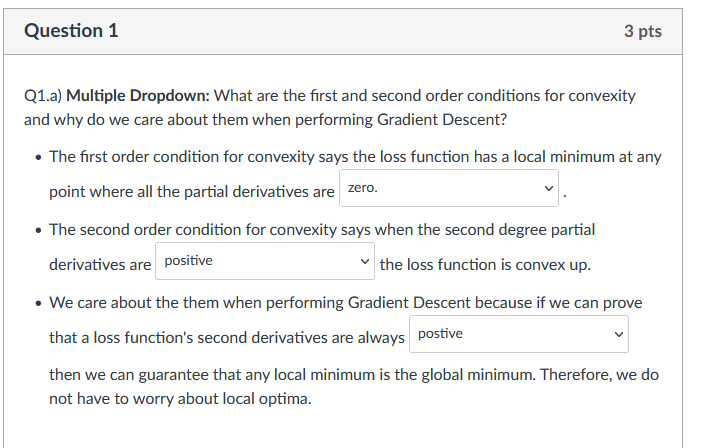

> 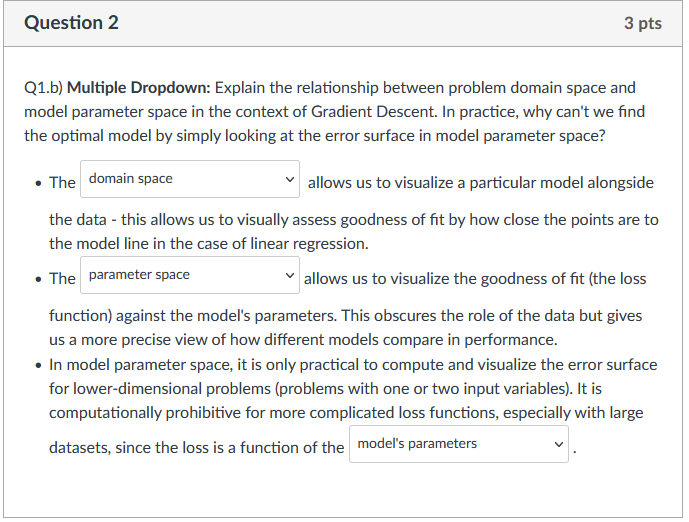

> 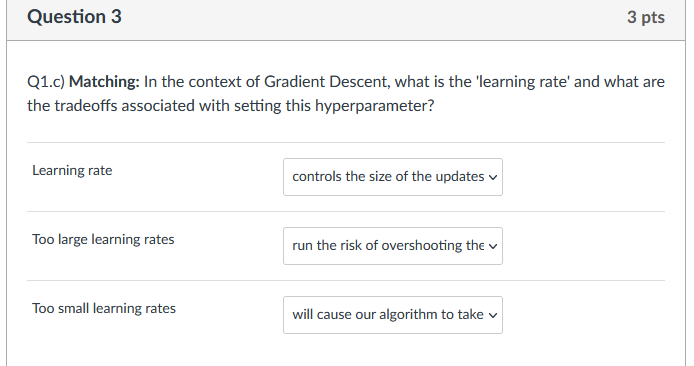
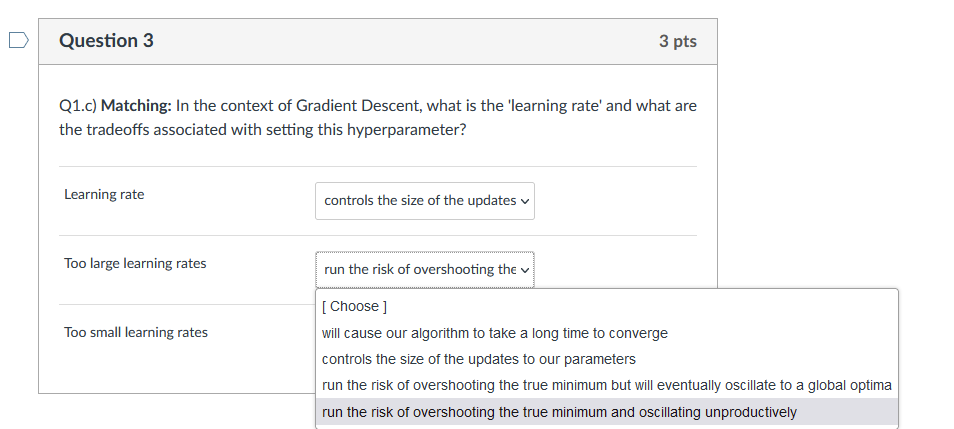


> 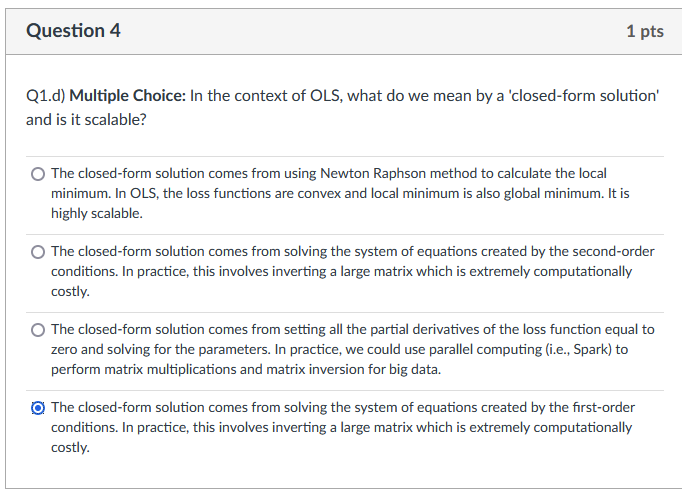

# Load data and do EDA

## About the Data

For the main task in this portion of the homework you will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_): TARGET Variable

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned `quality` score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.  Use the following cells to download the data, add a field for red/white, and split it into a test and train set.

In [6]:
# make a data folder & download red & white wine files
!mkdir data
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [ ]:
!ls -l data

In [9]:
!head data/reds.csv

"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5
11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.4;0.66;0;1.8;0.075;13;40;0.9978;3.51;0.56;9.4;5
7.9;0.6;0.06;1.6;0.069;15;59;0.9964;3.3;0.46;9.4;5
7.3;0.65;0;1.2;0.065;15;21;0.9946;3.39;0.47;10;7
7.8;0.58;0.02;2;0.073;9;18;0.9968;3.36;0.57;9.5;7


In [6]:
HW4_FOLDER

'gs://w261-hr/notebooks/jupyter/Assignments/HW4'

In [7]:
# put data on personal bucket - RUN THIS CELL AS IS
data_loc = f'{HW4_FOLDER}/data/reds.csv'
!cat data/reds.csv | gsutil cp - {data_loc}   
data_loc = f'{HW4_FOLDER}/data/whites.csv'
!cat data/whites.csv | gsutil cp - {data_loc}                                    

Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


In [8]:
!gsutil ls -l {HW4_FOLDER}

       801  2023-07-04T03:19:26Z  gs://w261-hr/notebooks/jupyter/Assignments/HW4/README.md
   3503596  2023-07-06T00:34:32Z  gs://w261-hr/notebooks/jupyter/Assignments/HW4/hw4_Workbook-HR.ipynb
     91944  2023-07-04T03:19:26Z  gs://w261-hr/notebooks/jupyter/Assignments/HW4/hw4_Workbook.ipynb
     47631  2023-07-04T22:10:31Z  gs://w261-hr/notebooks/jupyter/Assignments/HW4/quiz.ipynb
                                 gs://w261-hr/notebooks/jupyter/Assignments/HW4/data/
TOTAL: 4 objects, 3643972 bytes (3.48 MiB)


In [9]:
# load data - RUN THIS CELL AS IS
data_loc = f'{HW4_FOLDER}/data/whites.csv'
!gsutil cat  -h  {data_loc}|head

==> gs://w261-hr/notebooks/jupyter/Assignments/HW4/data/whites.csv <==
"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9.5;6
8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;10.1;6
7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6
7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6
8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;10.1;6
6.2;0.32;0.16;7;0.045;30;136;0.9949;3.18;0.47;9.6;6
7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9.5;6


In [10]:
# extract header fields - RUN THIS CELL AS IS
header = !head -n 1 data/reds.csv
header = header[0]
FIELDS = ['color'] + re.sub('"', '', header).split(';')

In [11]:
# load the raw data into an RDD - RUN THIS CELL AS IS
data_loc = f'{HW4_FOLDER}/data/reds.csv'
redsRDD = sc.textFile(data_loc)\
            .filter(lambda x: x != header)\
            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
data_loc = f'{HW4_FOLDER}/data/whites.csv'
whitesRDD = sc.textFile(data_loc)\
              .filter(lambda x: x != header)\
              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine
redsRDD.count(), whitesRDD.count()

23/07/06 00:35:59 WARN org.apache.hadoop.util.concurrent.ExecutorHelper: Thread (Thread[GetFileInfo #0,5,main]) interrupted: 
java.lang.InterruptedException
	at com.google.common.util.concurrent.AbstractFuture.get(AbstractFuture.java:510)
	at com.google.common.util.concurrent.FluentFuture$TrustedFuture.get(FluentFuture.java:88)
	at org.apache.hadoop.util.concurrent.ExecutorHelper.logThrowableFromAfterExecute(ExecutorHelper.java:48)
	at org.apache.hadoop.util.concurrent.HadoopThreadPoolExecutor.afterExecute(HadoopThreadPoolExecutor.java:90)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1157)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
23/07/06 00:35:59 WARN org.apache.hadoop.util.concurrent.ExecutorHelper: Thread (Thread[GetFileInfo #1,5,main]) interrupted: 
java.lang.InterruptedException
	at com.google.common.util.concurrent.AbstractFuture.get(AbstractFuture.java:510)
	at c

(1599, 4898)

In [14]:
redsRDD.take(5)

['1;7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5',
 '1;7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5',
 '1;7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5',
 '1;11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6',
 '1;7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5']

In [12]:
# Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed=1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 1316 records for evaluation and assigned 5181 for training.


In [16]:
import pandas as pd
pd.DataFrame(trainRDD.map(lambda line: line.split(';')).take(5), columns=["color", "fixed acidity","volatile acidity","citric acid",
                                        "residual sugar","chlorides","free sulfur dioxide",
                                        "total sulfur dioxide","density","pH","sulphates","alcohol","quality"])

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,1,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
2,1,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6
3,1,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
4,1,7.4,0.66,0,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


In [13]:
# helper function - RUN THIS CELL AS IS
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split(';'), dtype = 'float')
    features,quality = fields[:-1], fields[-1]
    return(features, quality)

In [14]:
# cache the training set - RUN THIS CELL AS IS 
trainRDDCached = trainRDD.map(parse).cache()

## ✅ Question 2: EDA

A statistician's approach to Linear Regression typically involves a series of EDA steps to examine each feature in the data and then a series of steps to test assumptions about their potential contribution to a multi-feature linear model. In particular, we'd want to look for a set of features that exhibit a likely linear relationship with the outcome variable and that are _not_ highy correlated with each other. In the context of machine learning, these considerations remain important techniques for improving model generalizability despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

In this question we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.

Here, we detour briefly and explore different methods of normality tests based on graphical methods and statistical methods.

#### Visual Normality Checks: historgrams and Q-Q plot
We can create plots of the data to check whether the each feature is Gaussian distributed. These checks are qualitative, so less accurate than the statistical methods we will calculate in the next section. Nevertheless, they are fast and like the statistical tests, must still be interpreted before you can make a call about your data sample. A simple and commonly used plot to quickly check the distribution of a sample of data is the histogram. A histogram can be created using the hist() matplotlib function. By default, the number of bins is automatically estimated from the data sample. If a variable's data, summarized using histrogram-based form, takes a bell-shape corresponding to  Gaussian-like shape, then we can qualitatively say it is is a normally-distributed variable. Another popular plot for checking the distribution of a data sample is the quantile-quantile plot, `Q-Q plot`, or QQ plot for short.

In this section, we will highlighted two common methods for visually inspecting a dataset to check if it was drawn from a Gaussian distribution.

#### Statistical Normality Tests
There are many statistical tests that we can use to quantify whether a sample of data looks as though it was drawn from a Gaussian distribution. Each test makes different assumptions and considers different aspects of the data.

We will list commonly used tests that one can apply to ones own data samples:

* Shapiro-Wilk test
* D’Agostino’s $K^2$ Test
* Anderson-Darling Test

We explore the Shapiro-Wilk test in detail. Please feel free to use any of these tests to check for normality of variable in a programmatic way. The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk. In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.

The Shapiro-Wilk is a hypotheses test and the two hypotheses are as follows:

* $H_o$(Accepted): Sample is from the normal distributions.(Po>0.05)
* $H_a$(Rejected): Sample is not from the normal distributions.

The `scipy.stats.shapiro()` SciPy function calculates the Shapiro-Wilk on a given dataset. The function returns both the W-statistic calculated by the test and the p-value. The complete example of performing the Shapiro-Wilk test on the dataset is given here:.

In [21]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.992, p=0.822
Sample looks Gaussian (fail to reject H0)


### Q2 Tasks:

* __a) Multiple Answers on Digital Campus:__ Run the provided code to sample 1000 points and visualize histograms of each feature. Which features appear normally distributed? (Select 2 answers)

* __b) Multiple Choice on Digital Campus:__ How is the varaible `color` different than the other features & what does that mean about how we interpret its regression coefficient?

* __c) Multiple Answers on Digital Campus:__ Run the provided code to create boxplots of each feature. Which, if any, appear to have a **positive** linear relationship with `quality`? (Select 1 answer)

* __d) Multiple Answers on Digital Campus:__ Which if any appear to have a **negative** linear relationship with `quality`? (Select 2 answers)

* __e) Multiple Answers on Digital Campus:__ Run the provided code to plot the correlations matrix. Which pairs of features are most _strongly_ (**postively**) associated with each other? (Select 2 answers)

* __f) Multiple Answers on Digital Campus:__ Which pairs of features are most _strongly_ (**negatively**) associated with each other? (Select 2 answers)

* __g) Multiple Choice on Digital Campus:__ What implications would that have for our feature selection?

    * A:  We would want to remove all combinations of these features that are highly correlated. For example, before modeling we should remove the following features from the training data: color, total sulfur dioxide and free sulfur dioxide combination.
    * B:  We would want to remove some combinations of these features in feature selection so they do not interfere with each other's predictive power. Some features to remove could be color and free sulfur dioxide, since they both correlate strongly with total sulfur dioxide.
    * C:  We should build a linear regression model using all available input features. Since multicollinearity is only important for a statistical model and does not affect a machine learning model.
    * D: None of the provided options is correct.


### Q2 Student Answers:

OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ Type your answer here!  

> __b)__ Type your answer here!  

> __c)__ Type your answer here!

> __d)__ Type your answer here!  

> __e)__ Type your answer here!  

> __f)__ Type your answer here!

> __g)__ Type your answer here!


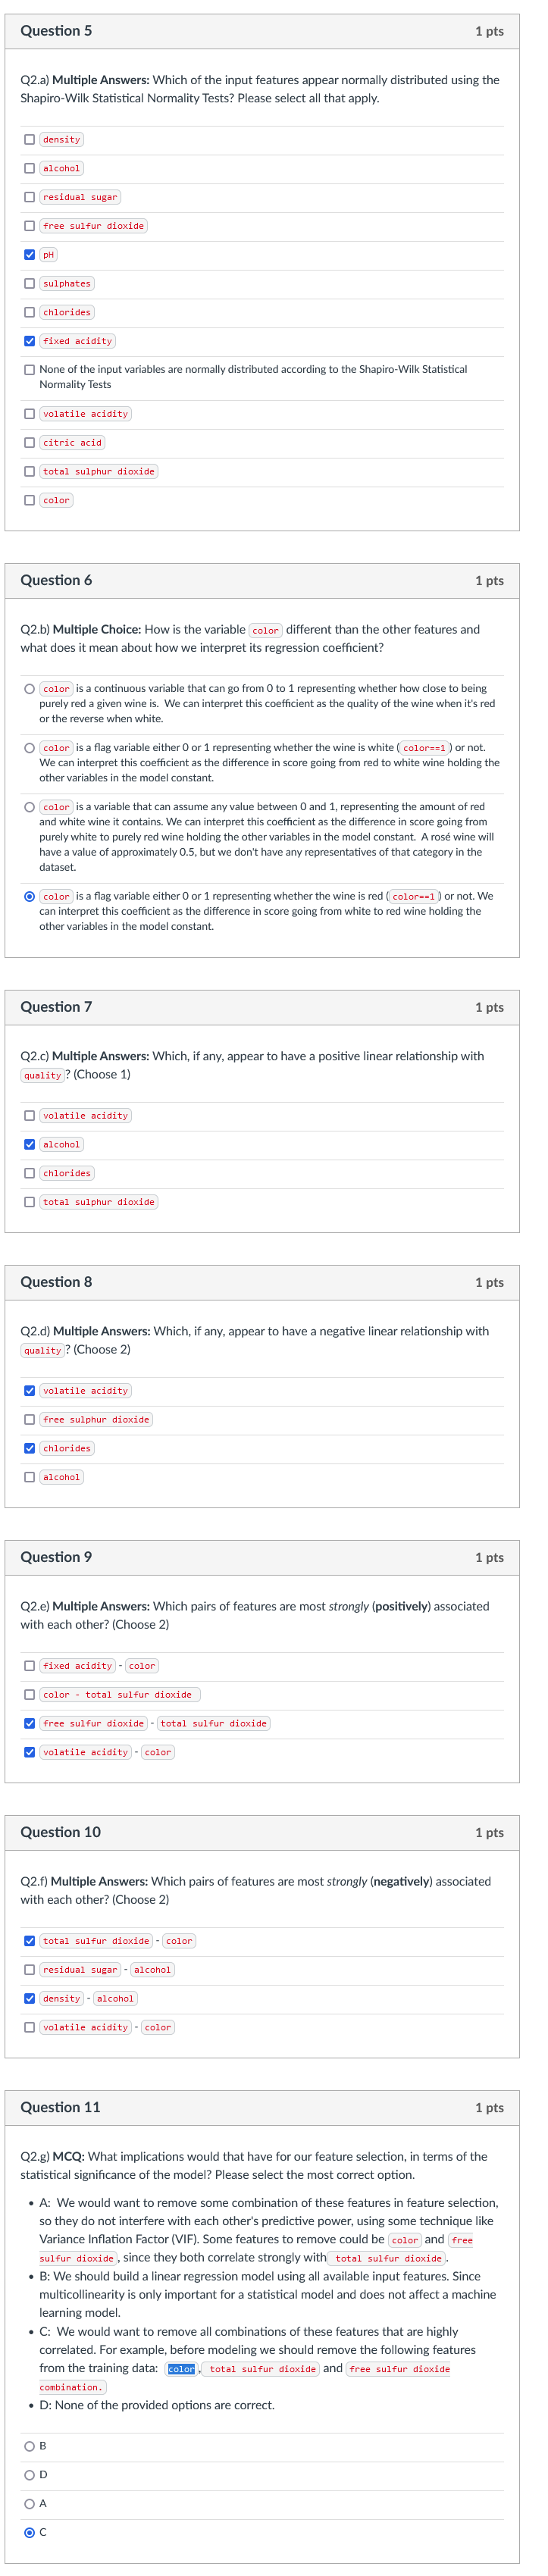

In [22]:
# part a - take a 1000 point sample for EDA (RUN THIS CELL AS IS)
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000, seed=2022))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)


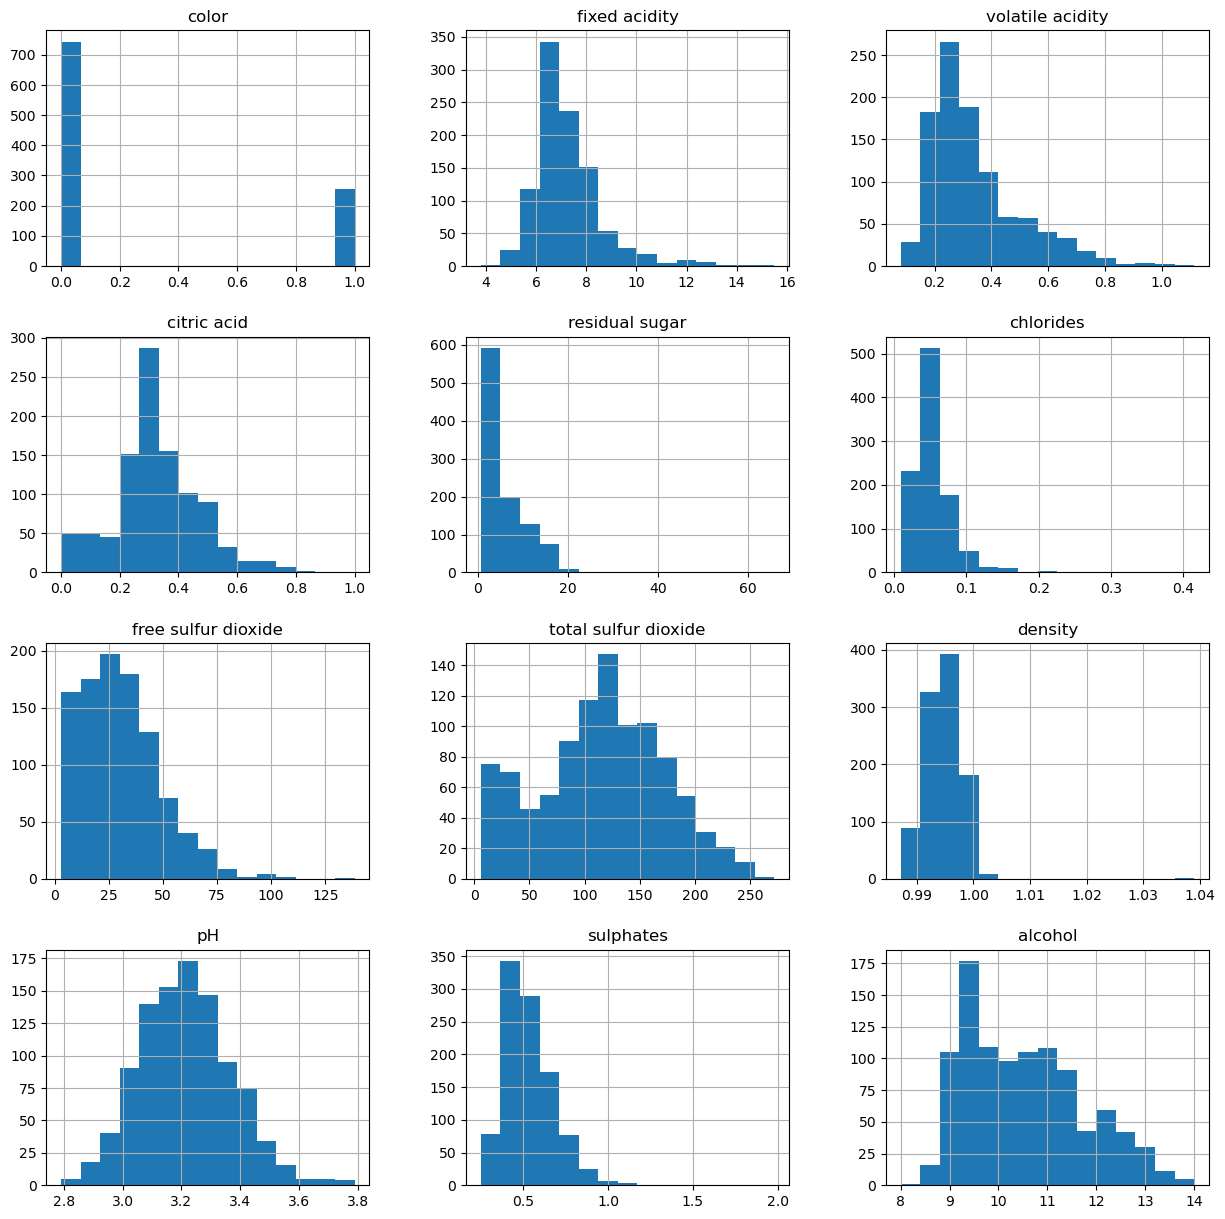

In [23]:
# part a1 - take a look at histograms for each feature (RUN THIS CELL AS IS)
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

In [24]:
# part a2 - take a look at the Shapiro-Wilk Statistical Normality Tests (RUN THIS CELL AS IS)
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# interpret
alpha = 0.05
for i in sample_df:
    stat, p = shapiro(sample_df[[i]])
    #print(sample_df[[i]])
    if p > alpha:
        print(f'Variable {i} looks Gaussian (fail to reject H0) at {p:0.5}')
    else:
        print(f'Variable {i} does NOT look Gaussian (reject H0)  at {p:.5}')

Variable color does NOT look Gaussian (reject H0)  at 5.6052e-45
Variable fixed acidity does NOT look Gaussian (reject H0)  at 3.9381e-27
Variable volatile acidity does NOT look Gaussian (reject H0)  at 3.3471e-26
Variable citric acid does NOT look Gaussian (reject H0)  at 2.1313e-12
Variable residual sugar does NOT look Gaussian (reject H0)  at 1.1314e-34
Variable chlorides does NOT look Gaussian (reject H0)  at 1.9146e-40
Variable free sulfur dioxide does NOT look Gaussian (reject H0)  at 4.5049e-18
Variable total sulfur dioxide does NOT look Gaussian (reject H0)  at 1.8588e-09
Variable density does NOT look Gaussian (reject H0)  at 1.4421e-26
Variable pH does NOT look Gaussian (reject H0)  at 0.00035225
Variable sulphates does NOT look Gaussian (reject H0)  at 2.567e-25
Variable alcohol does NOT look Gaussian (reject H0)  at 4.2434e-17
Variable quality does NOT look Gaussian (reject H0)  at 8.5522e-27


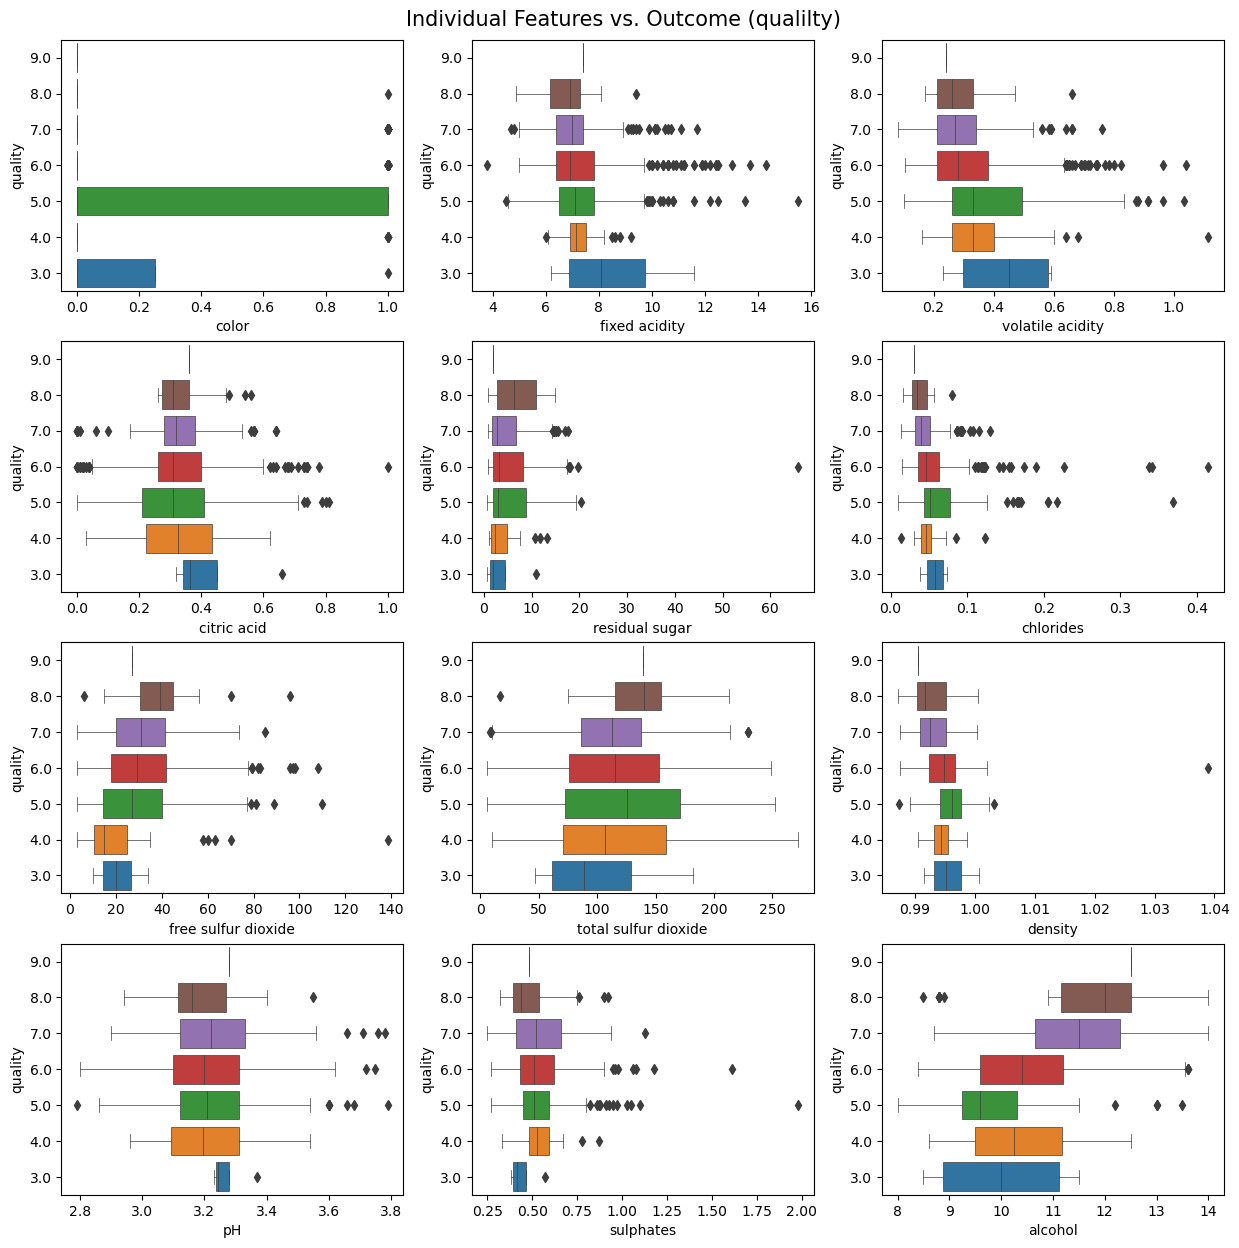

In [25]:
# part b -  plot boxplots of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))
y = sample_df['quality']
for idx, feature in enumerate(FIELDS[:-1]):
    x = sample_df[feature]
    sns.boxplot(x=x, y=y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

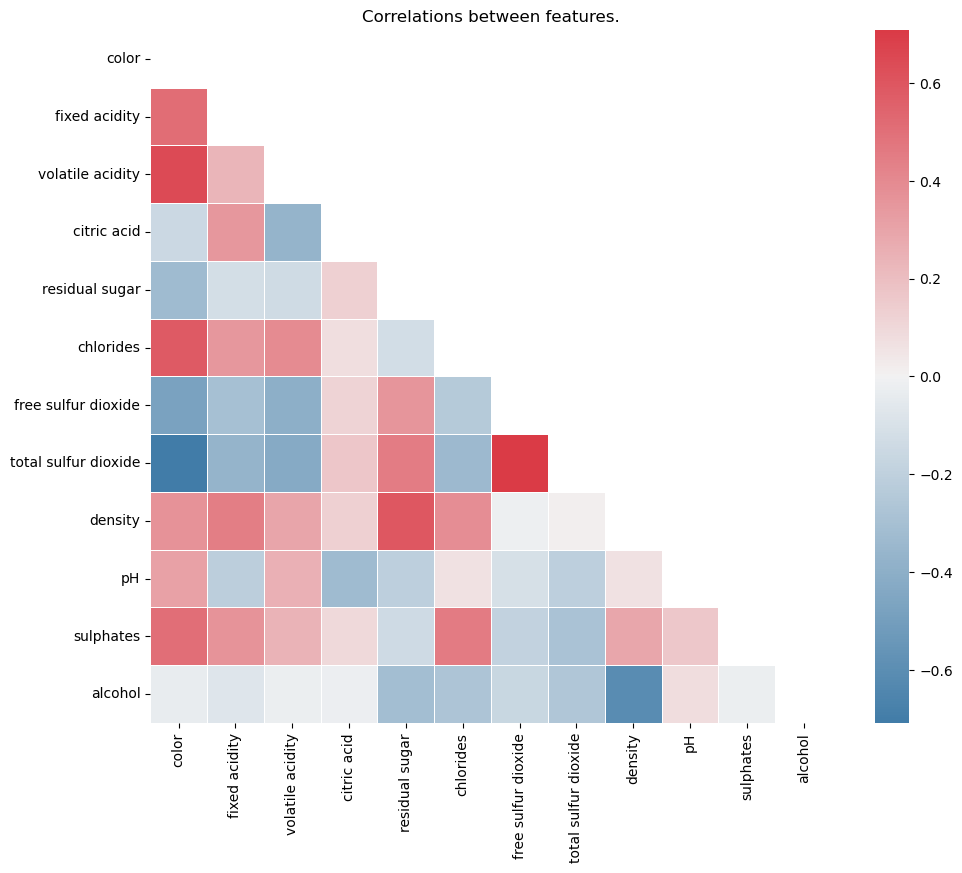

In [28]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

# ✅ Question 3: OLS Loss

For a parametric model, the key factor that will impact how easy it is to optimize is your choice of how to define the loss function. In Ordinary Least Squares (OLS) Regression our loss function is just about as convenient as you will get: not only is it convex, its also very easy to interpret. 

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. It is useful as a simple baseline to compare with other (real) regressors. Examples of regression baselines include:
* "mean": always predicts the mean of the training set
* "median": always predicts the median of the training set
* "quantile": always predicts a specified quantile of the training set,provided with the quantile parameter.
* "constant": always predicts a constant value that is provided by the user.

In this question you'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. You'll reuse this function in Q4 when you implement gradient descent.

#### Baseline example illustrated:

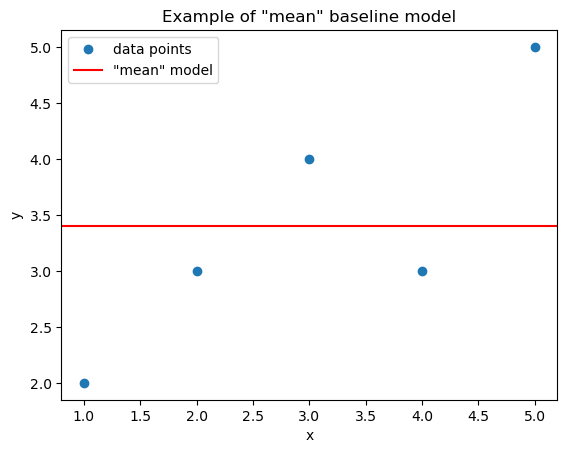

In [29]:
# points from our mini example from the demo 6 notebook
points = np.array([[1,2],[3,4],[5,5],[4,3],[2,3]])
x = points[:,0]
y = points[:,1]

plt.figure()
plt.plot(x, y,'o', label='data points')
plt.axhline(np.mean(y),c='r', label='"mean" model')
plt.title('Example of "mean" baseline model')
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.show()

### Q3 Tasks:
* __a) code + numeric answer on Digital Campus:__ Fill in the code below to compute the mean of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]

* __b) code + numeric answer on Digital Campus:__ Fill in the code below to compute the variance of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]

* __c) Multiple Choice on Digital Campus:__ Which is the correct formula and interpretation for the OLS loss function?

* __d) Multiple Choice on Digital Campus:__ In the context of linear models & vector computations what does it mean to 'augment' a datapoint and why do we do this?

* __e) code:__ Fill in the missing code to complete the`OLSLoss` function. [__`TIP:`__ Use `augmentedData` as your input when computing the loss.]

* __f) Multiple Choice on Digital Campus:__ Is computing the loss "embarassingly parallel"?

* __g) code + numeric answer on Digital Campus:__ Fill in the missing code to define a baseline model for this data set that has a bias term equal to the mean of your outcome variable and `0.0` for all coefficients. Note that in the docstring for `OLSLoss` we specified that the model should be a numpy array with the bias in the first position. Once you've defined your model, run the provided cells to check that your model has the correct dimensions and then compute the loss for your baseline model.

* __h) Multiple Choice on Digital Campus:__  Compare your results in part __g__ to the result you got in part __a__. What is the explanation?

### Q3 Student Answers:

OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ Type your answer here!  

> __b)__ Type your answer here!  

> __c)__ 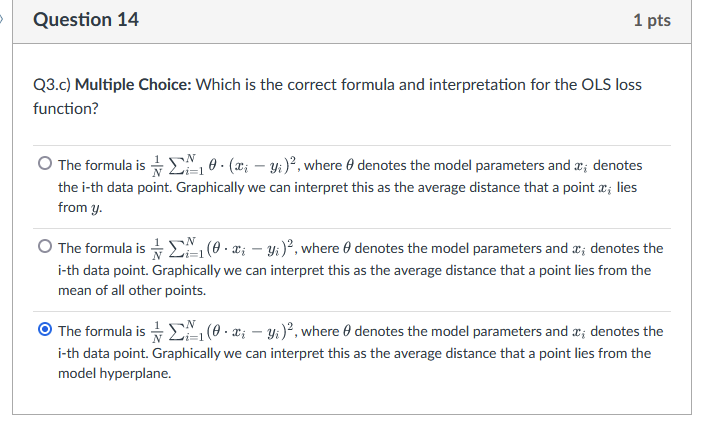

> __d)__ 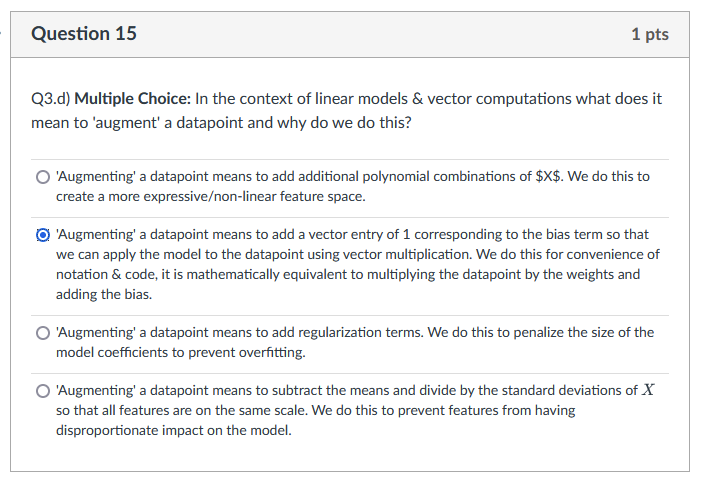

> __f)__ 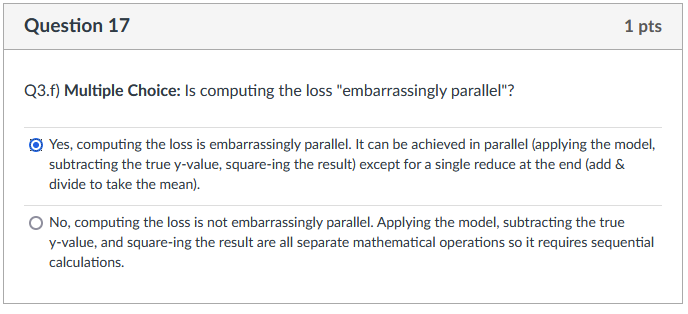

> __g)__ Type your answer here!

> __h)__ 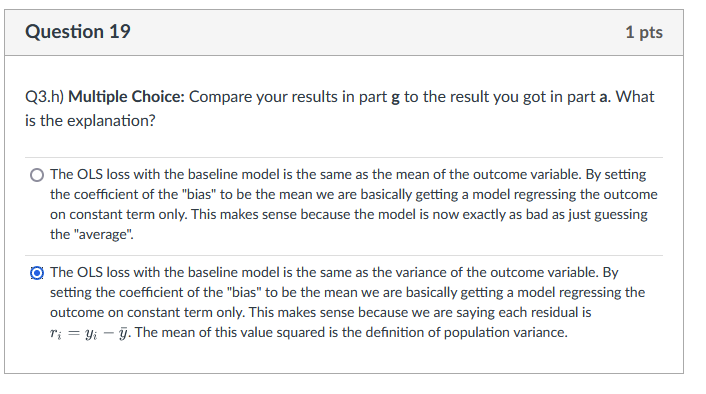

In [15]:
# part a - mean of the outcome variable 
meanQuality = trainRDDCached.map(lambda x: x[1]).mean()   # FILL IN YOUR CODE HERE
print(f"Mean: {meanQuality}")
# EXPECTED OUTPUT: 5.811040339702759

Mean: 5.811040339702759


In [16]:
# part b - variance of the outcome variable 
varQuality = trainRDDCached.map(lambda x: x[1]).variance()   # FILL IN YOUR CODE HERE
print(f"Variance: {varQuality}")
# EXPECTED OUTPUT: 0.760086564865664

Variance: 0.760086564865664


In [17]:
# part e - write function to compute loss (FILL IN MISSING CODE BELOW)
def OLSLoss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    wBroadcast = sc.broadcast(W)
    loss = augmentedData.map(lambda x: (np.dot(x[0], wBroadcast.value) - x[1])**2).mean()
    ################## (END) YOUR CODE ##################
    return loss

In [18]:
# part g - define your baseline model here
BASELINE = np.append([meanQuality], np.zeros(len(trainRDDCached.take(1)[0][0])))   # FILL IN YOUR CODE HERE
BASELINE

array([5.81104034, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [19]:
# part g - compute the loss for your baseline model (RUN THIS CELL AS IS)
assert len(BASELINE) == len(trainRDDCached.take(1)[0][0]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {OLSLoss(trainRDDCached, BASELINE)}")
# EXPECTED OUTPUT: 0.7600865648656636

Baseline model loss: 0.7600865648656636


# ✅ Question 4: Vanilla Gradient Descent

Performing Gradient Descent technically only requires two steps: 1) _use the current model to calculate the gradient_; 2) _use the gradient to update the current model parameters_. In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if its working. In this question you'll implement gradient descent for OLS regression and take a look at a few update steps.

### Q4 Tasks:
* __a) Multiple Choice on Digital Campus:__ Select the correct statements regarding the augmentation of data in terms of machine learning

* __b) Short Essay on Digital Campus:__ The size of the update for gradient descent is influenced by two factors:
    * The learning rate. Let's assume it is a constant here as therefore can be dropped from further discussion with regard to this question.
    * Gradient vector:
      * In OLS Regression the gradient vector is composed of two terms:
        * The training data
        * The error term
      * In plain language, the gradient vector is  **the weighted average of the training data where each example is weighted by its associated error**.
      * To keep things simple, assume we are using all the training data to calculate the gradient vector.

    __TASK__: As part of your response, please provide the formula for the gradient (__in Latex__) to reflect this plain language summary. Then explain under what circumstances you would have a large gradient and large subsequent update, and under what circumstances you would have a small gradient and small subsequent update.
    
    (Hint: discuss in terms of those two core terms)

* __c) Matching on Digital Campus:__ Examine the formula you wrote in question Q4(a2). With a gradient descent implementation in Spark Map-Reduce framework, for learning a linear regression model as the context, please match each Left Hand Side question with the most appropriate Right Hand Side response.

* __d) Fill in Blanks on Digital Campus:__ The mean squared error (MSE) loss function, which is a metric used to evaluate a simple Linear Regression model is defined as the following: 
$$\text{MSE}(\mathbf{w_1,w_0}; \mathbf{X,y}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{( \mathbf{w_1} \mathbf{x}^{(i)}+ \mathbf{w_0} - y^{(i)})^2}$$
    where,
    $$X = \begin{bmatrix}
    - \ \mathbf x_1^T - \\ 
      \vdots  \\ 
    - \ \mathbf x_m^T -   \\ 
    \end{bmatrix} = \begin{bmatrix}
    x_{11} &; \cdots &; x_{1n}  \\ 
     &;  \ddots &;  \\ 
    x_{m1} &; \cdots &; x_{mn}  \\ 
    \end{bmatrix}$$
    $m$ traning examples $(x_i, y_i)$
    
    $n$ features, $\mathbf x_i = \big[x_{i1}, \ ... \ , x_{in} \big]^T \in \mathbb{R}^n$
    
    the observed target values $\mathbf y = \begin{bmatrix} y_1 \\ \vdots \\ y_m\end{bmatrix} \in \mathbb{R}^{m}$
    
    With respect to Linear Regression Loss function, in Coordinate Geometry, the model coefficient $w_1$ is more commonly known as the `[value1]`, while $w_0$ is more commonly known as the `[value2]`.  Please answer the `[value 1]` and `[value 2]` in the blank. (Expect a single word for `[value1]`, `[value2]`)

* __e) Code:__ Fill in the missing lines in `GDUpdate` to compute the gradient and perform a single update of the model parameters.   
    * __`TIP 1:`__ _remember that the gradient is a vector of partial derivatives, `grad` should be a numpy array_    
    * __`TIP 2:`__ _Spark's built in `mean()` function may help you here_  


* __f) Multiple Choice on Digital Campus:__ Run the provided code to perform 5 steps of Gradient Descent on our data. What is wrong with these results?

* __g) Code:__ Fill in the missing code in `normalize` so that this function scales each feature and centers it at 0. Then use the provide code block to rerun your same gradient descent code on the scaled data. 

* __h) Multiple Choice on Digital Campus:__ Use these results to explain what the problem was in question '4f'.
 

### Q4 Student Answers:

OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ 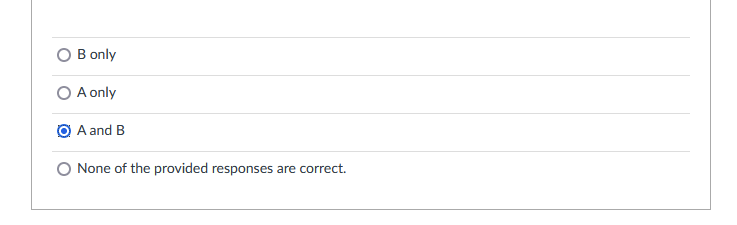

> __b)__ 

The formula for the gradient is given by : 


$$
\frac{2}{n} \sum_{i=1}^n [\theta^T \cdot x'_i - y_i] \cdot x_i
$$


A large gradient and subsequent update would occur under the scenario where we have a very large error (i.e. the weight of the average is really large), assuming all our features have been normalized (there's a trivial case where if the feature values are really large, the steps will be large, too). If our initial model was really far off from the optimal weights, then it makes sense for the model to move in a really large step in the optimal direction.

A small gradient / update would occur under the complement of the previous scenario, where the residual is super small and therefore we are in the vicinity of the optimal solution. A small step then makes sense to arrive at a local/global optimum.
The formula for the gradient is given by : .

A large gradient and subsequent update would occur under the scenario where we have a very large error (i.e. the weight of the average is really large), assuming all our features have been normalized (there's a trivial case where if the feature values are really large, the steps will be large, too). If our initial model was really far off from the optimal weights, then it makes sense for the model to move in a really large step in the optimal direction.

A small gradient / update would occur under the complement of the previous scenario, where the residual is super small and therefore we are in the vicinity of the optimal solution. A small step then makes sense to arrive at a local/global optimum.

> __c)__ 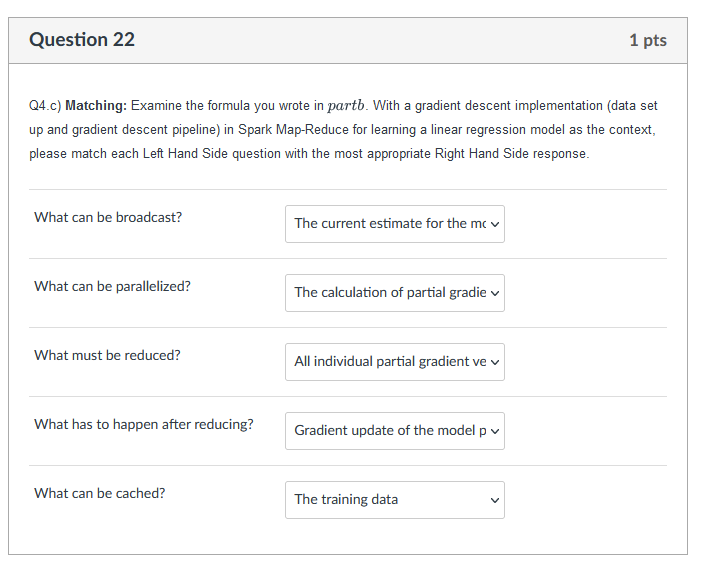

> __d)__ 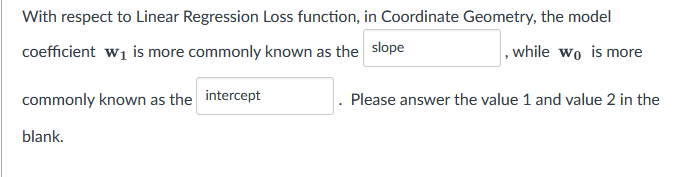

> __e)__ complete the coding portions of this question before answering f

> __f)__ 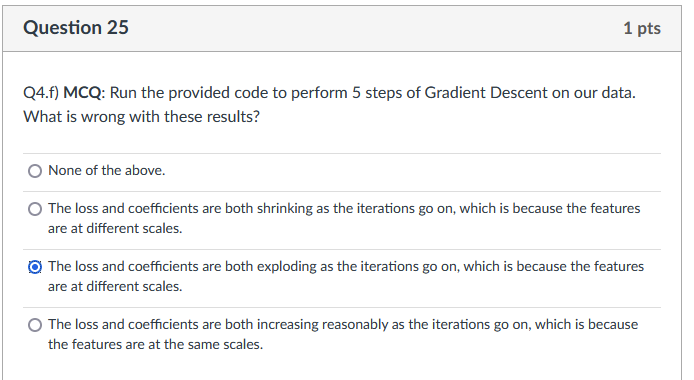

> __g)__ complete the coding portions of this question before answering h 

> __h)__ 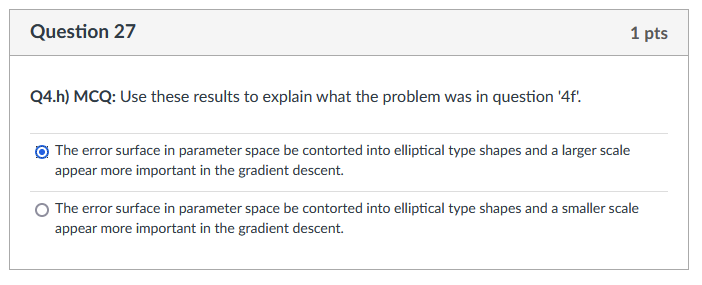


In [20]:
# part e - function to perform a single GD step
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    ################## YOUR CODE HERE #################
    wBroadcast = sc.broadcast(W)
    grad = 2*augmentedData.map(lambda d: d[0] * (np.dot(d[0], wBroadcast.value) - d[1])).mean()
    new_model = W - learningRate*grad
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [43]:
%%time
# part f - take a look at a few Gradient Descent steps (RUN THIS CELL AS IS)

nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(trainRDDCached, model)
    loss = OLSLoss(trainRDDCached, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656636
----------
STEP: 1
Loss: 3255.0397706648127
Model: [5.811, -0.009, -0.017, -0.007, 0.002, -0.035, -0.001, 0.167, -0.489, -0.0, 0.0, 0.001, 0.094]
----------
STEP: 2
Loss: 41538896320.90074
Model: [15.998, 0.946, 71.311, 3.109, 3.394, 67.104, 0.517, 372.213, 1469.681, 10.133, 32.587, 5.197, 105.407]
----------
STEP: 3
Loss: 5.321516254246975e+17
Model: [-36732.224, -3790.819, -257459.013, -11294.195, -12193.785, -240557.886, -1880.28, -1359608.579, -5252902.327, -36544.479, -117571.505, -18781.008, -379946.295]
----------
STEP: 4
Loss: 6.817355374095457e+24
Model: [131498780.95, 13574790.866, 921540888.277, 40426173.604, 43645471.549, 861027822.897, 6730358.366, 4867148463.848, 18801163135.814, 130805962.538, 420832007.136, 67225003.981, 1359973545.811]
----------
STEP: 5
Loss: 8.733663880159667e+31
Model: [-470665198626.592, -48587550191.15, -3298412689019.937, -144694834630.261, -156217444459.899, -3081821742976.596, -24089547803.278, -174206930645

<b> Question 4F Expected Output <b>


<img src='https://github.com/UCB-w261/w261-environment/blob/master/hw-images/HW4%20Expected%20Outputs/Q4F%20Expected%20Output.png?raw=true' style='width:80%'>

In [21]:
# part g - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    
    ################ YOUR CODE HERE #############
    normedRDD = dataRDD.map(lambda x: ( ((x[0] - featureMeans) / featureStdev), x[1]) )
    ################ FILL IN YOUR CODE HERE #############
    
    return normedRDD

In [22]:
# part g - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(trainRDDCached).cache()

In [46]:
%%time
# part g - take a look at a few GD steps w/ normalized data  (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD, model)
    loss = OLSLoss(normedRDD, model) 
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656636
----------
STEP: 1
Loss: 0.6555276691703891
Model: [5.811, -0.02, -0.014, -0.045, 0.014, -0.007, -0.035, 0.009, -0.009, -0.054, 0.003, 0.008, 0.078]
----------
STEP: 2
Loss: 0.615059239044261
Model: [5.811, -0.022, -0.014, -0.071, 0.023, -0.006, -0.05, 0.014, -0.021, -0.079, 0.007, 0.024, 0.131]
----------
STEP: 3
Loss: 0.5935522582531458
Model: [5.811, -0.018, -0.01, -0.09, 0.03, 0.002, -0.057, 0.02, -0.032, -0.09, 0.011, 0.04, 0.167]
----------
STEP: 4
Loss: 0.5798853360580277
Model: [5.811, -0.014, -0.006, -0.105, 0.034, 0.012, -0.061, 0.026, -0.04, -0.094, 0.013, 0.054, 0.195]
----------
STEP: 5
Loss: 0.5703196233260643
Model: [5.811, -0.009, -0.003, -0.117, 0.036, 0.024, -0.063, 0.032, -0.047, -0.096, 0.016, 0.066, 0.217]
CPU times: user 93 ms, sys: 31.9 ms, total: 125 ms
Wall time: 1.72 s


<b> Question 4G Expected Output <b>


<img src='https://github.com/UCB-w261/w261-environment/blob/master/hw-images/HW4%20Expected%20Outputs/Q4G%20Expected%20Output.png?raw=true' style='width:80%'>

# ✅ Question 5: Assessing the performance of your model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but this number doesn't accurately reflect "how good" our model is. In this question, you'll plot error curves for a test set and training set in order to discuss the model performance. Note that although we have split out a test set & train set when we first loaded the data, in the spirit of keeping that 20% test set truly 'held out' until the end of the assignment, we'll make an additional split for the purposes of this question, and divide the existing training set into two smaller RDDs.

### Q5 Tasks:

* __a) Multiple Choice on Digital Campus:__ Why doesn't the loss that we printed in Question 4 accurately reflect "how good" our model is? 


* __b) Code:__ Since we're going to be running Gradient Descent for a number of times, let's package it into a function. Fill in the missing code in the `GradientDescent()` function. (Feel free to use the provided code blocks as a starting point.)


* __c) Multiple Choice on Digital Campus:__ Use the provided code to split the normalized data into a test set and train set, then run 50 iterations of gradient descent and plot the MSE curves for each. Describe what you see and speculate about why this might be happening.


* __d) Short Answer on Digital Campus:__ Note that passing the optional parameter `seed` to the Spark method `randomSplit()` allows us to pseudo randomize our test/train split in a way that is replicable. Run the code similar to 'Q5c' in the line where we perform the `normedRDD.randomSplit()` with the seed set to `seed = 5` and `seed = 4`.  What is the difference you notice between the plots in Q5c, and in Q5d when the seed is set to 5 and 4? Explain why you think this difference occurs and propose at least one approach to give us more reliable results in the future.

### Q5 Student Answers:

OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ 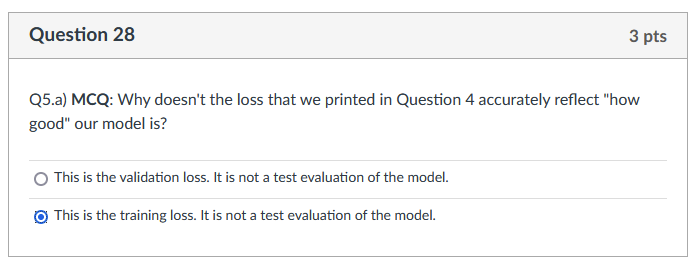  

> __c)__ 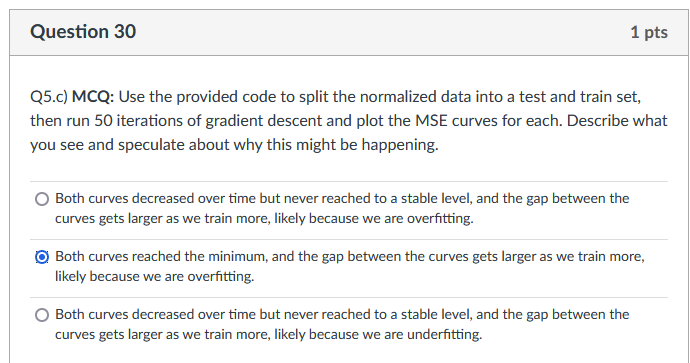

> __d)__ The pseudo-random process that is splitting the data based on that seed is producing at `seed = 4` a particular test set that is similar to the training set, which ultimately performs better for the model found by optimizing the loss function on the training set. In this particular case, the training set is giving us more information about the test set (so it generalizes better), than the split that resulted from `seed = 5`. This result is due simply to sampling variance and does not necessarily mean our model is better. A good way to make this more robust is to perform cross validation.


In [23]:
# part b - OLS gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        model = GDUpdate(trainRDD, model)
        training_loss = OLSLoss(trainRDD, model)
        test_loss = OLSLoss(testRDD, model)
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [24]:
# part c - plot error curves - (RUN THIS CELL AS IS)
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    display(plt.show())

In [25]:
# part c - run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 18.786096811294556 seconds


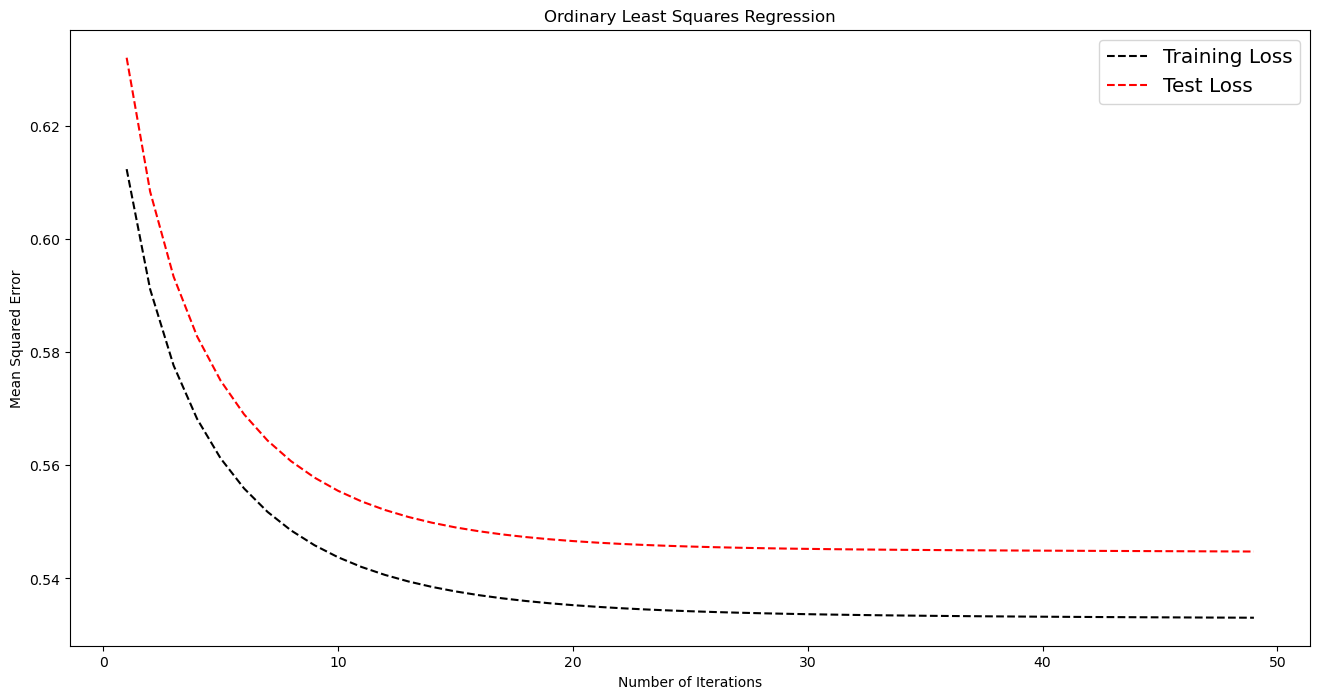

None

In [50]:
# part c - take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

<b> Question 5C Expected Output <b>


<img src='https://github.com/UCB-w261/w261-environment/blob/master/hw-images/HW4%20Expected%20Outputs/Q5C%20Expected%20Output.png?raw=true' style='width:60%'>

In [27]:
# part c - Save the models & their performance for comparison later (RUN THIS CELL AS IS)
np.savetxt('/data/OLSmodels.csv', np.array(models), delimiter=',')
np.savetxt('/data/OLSloss.csv', np.array([MSEtrain, MSEtest]), delimiter=',')

In [28]:
# part c - Put data on personal bucket (RUN THIS CELL AS IS)
data_loc = f'{HW4_FOLDER}/data/OLSmodels.csv'
!cat data/OLSmodels.csv | gsutil cp - {data_loc}
data_loc = f'{HW4_FOLDER}/data/OLSloss.csv'
!cat data/OLSloss.csv | gsutil cp - {data_loc}

Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


In [53]:
# part d - run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 16.052618741989136 seconds


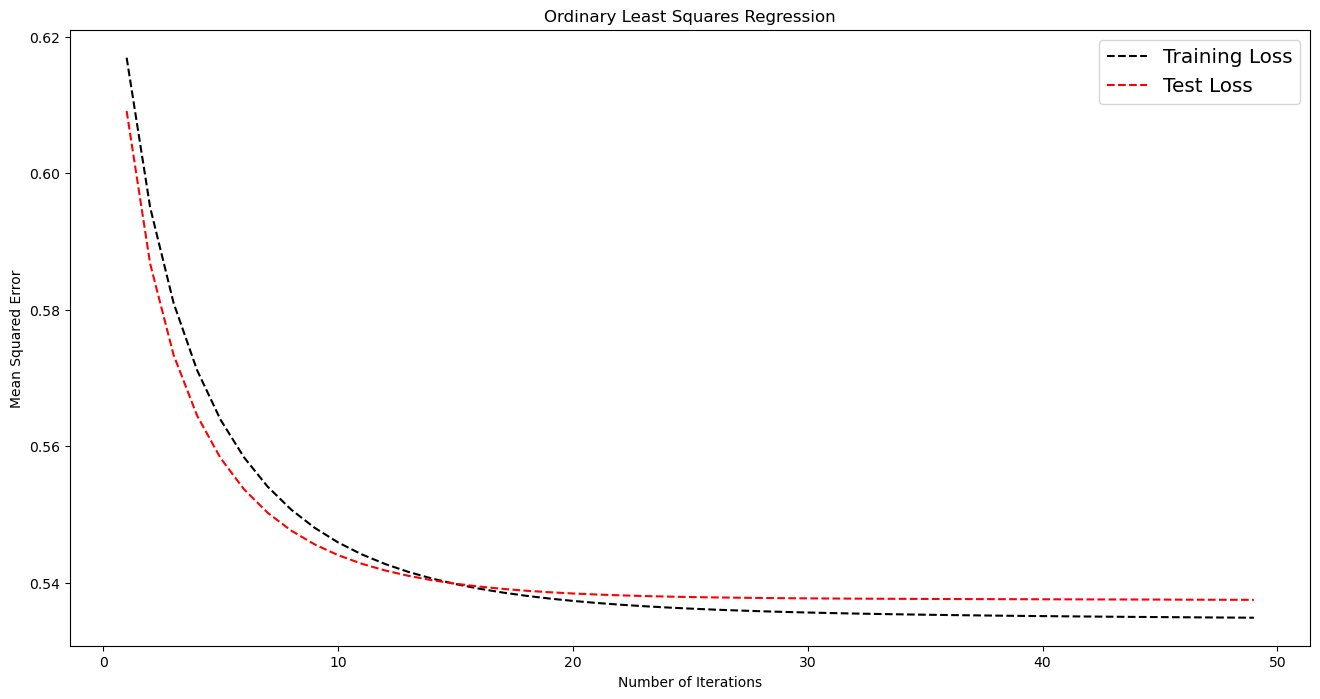

None

In [54]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

<b> Question 5D Expected Output <b>


<img src='https://github.com/UCB-w261/w261-environment/blob/master/hw-images/HW4%20Expected%20Outputs/Q5D_1%20Expected%20Output.png?raw=true' style='width:60%'>

In [134]:
# part d - run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 4)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 14.769869327545166 seconds


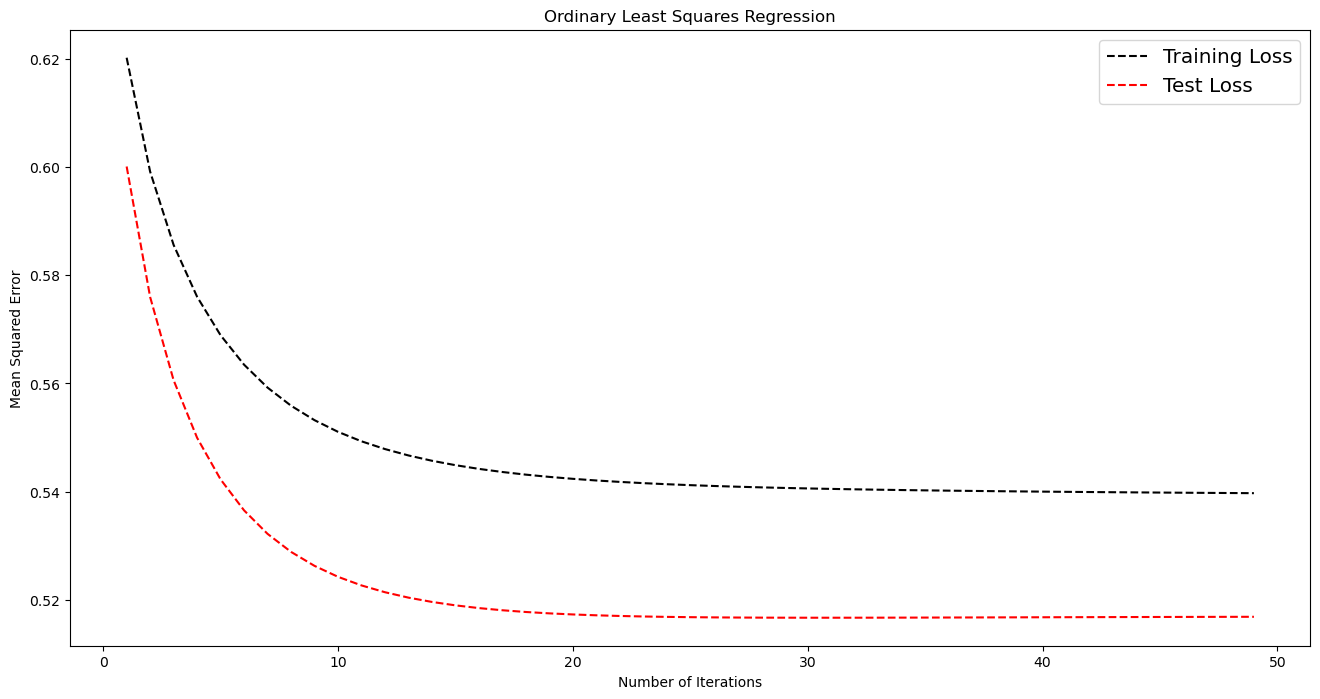

None

In [135]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

<b> Question 5D Expected Output <b>


<img src='https://github.com/UCB-w261/w261-environment/blob/master/hw-images/HW4%20Expected%20Outputs/Q5D_2%20Expected%20Output.png?raw=true' style='width:60%'>

# ✅ Question 6: Cross Validation

In question 5 we mentioned that computing the loss after each iteration is not strictly a part of Gradient Descent, its just convenient for visualizing our progress. This "third step" however comes with a tradeoff: it requires an extra pass through the data. Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place where no shuffle is needed for the aggregation. 

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), sometimes called rotation estimation, or out-of-sample testing. It is a model validation technique for assessing how well the model will generalize to an independent data set. The goal of cross-validation is to test the model's ability to predict new data. 

Cross validation, which will solve the problem of the unreliable test-loss that we saw in question 5, presents a bit more of a scalability challenge. To avoid over-dependence on a particulary good or bad train/test split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the train/test loss for each model. In this question we've provided a code base to perform gradient descent and cross validation in parallel. You'll fill in some of the key details based on your understanding from questions 1-5.

#### From ISLR Chapter 5.1 - Cross Validation
<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/CV-ISLRp181.png?raw=true">


### Q6 Tasks:
* __a) Numerical answer on Digital Campus:__ A naive approach to training an OLS Regression model with cross validation might be to simply perform Gradient Descent on each of the 5 models in sequence. In this naive approach, how many total passes would be made over the data for training? 

    [__`HINT:`__ _it will depend on the number of factors/ operations required during training, and does not include calculating the test loss_]


* __b) Multiple Dropdowns on Digital Campus:__ Read through the provided helper function `kResiduals()` and note where it gets used in the subsequent function `CVLoss()`. 
    * For each record in the original dataset, how many tuples does `kResiduals()` emit for each model? 
    * What are the keys of these newly emitted records?


* __c) Short Answer on Digital Campus:__ How will these keys help us compute cross validated loss?


* __d) Code:__ Complete the missing Spark code in `CVLoss()` so that this function returns the test/train cross validated error for a given set of data splits, and their corresponding models. 

    [__`TIP:`__ _your goal is to start from `partialLossRDD` and compute the test & train loss for each model so that the provided code can take the final average_].


* __e) Code:__ Read through the provided functions `partialGradients()` and `CVUpdate()`. These should have a familiar feel. Fill in the missing line in `CVUpdate()` to update each model and add the (new) array of coefficients to the `new_models` list. 


* __f) Multiple Choice on Digital Campus:__ Read `GradientDescent_withCV()` and then run the provided code to perform 50 iterations and plot the error curves. What can you conclude from this graph?

### Q6 Student Answers:

OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ Presumably this *does* include calculating the training loss, so it's one pass for training, and one for the calculating the loss for each of the k-folds (5) so $2*5 = 10$, without counting the pass that it does for augmentation.

> __b)__ 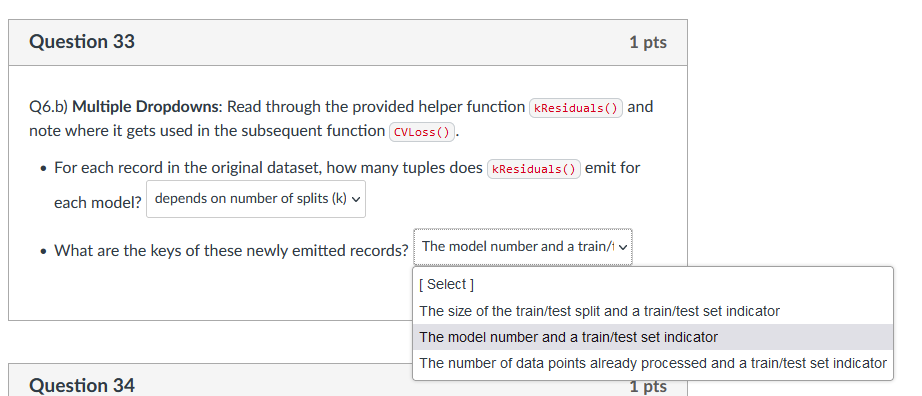

> __c)__ These keys will allow us to group the partial losses by model and type of data set and will allows us to subsequently reduce within each group to get the correct loss for each model.These keys will allow us to group the partial losses by model and type of data set and will allows us to subsequently reduce within each group to get the correct loss for each model.

> __f)__ 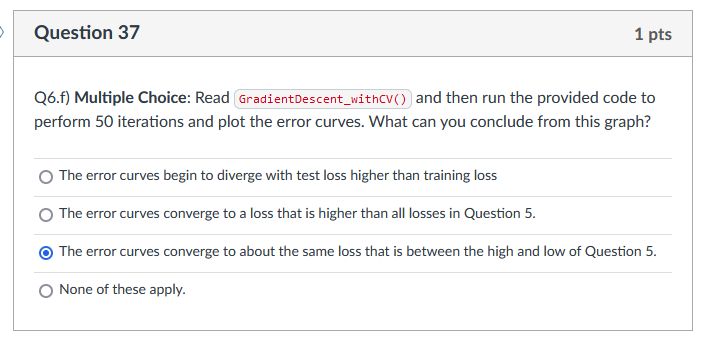

In [124]:
# part b - helper function to emit residuals (RUN THIS CELL AS IS)
def kResiduals(dataPoint, models, splitNum):
    """
    Compute the (squared) residuals for a data point given k different models.
    Note that points from the k-th split are part of the test set for model number k
    and part of the training set for all other models. We'll emit a key to track this.
    Args:
        dataPoint - tuple of (features_array, y)
        models    - list of arrays representing model weights (bias at index 0)
    Returns:
        (stringFormattedKey, squared_error)
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit squared residuals for each model
    for modelNum, W in enumerate(models):
        if modelNum == splitNum:
            yield(f"{modelNum}-test", (W.dot(X) - y)**2)
        else:
            yield(f"{modelNum}-train", (W.dot(X) - y)**2)

In [136]:
# part d - fill in the missing code below
def CVLoss(dataSplits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    Args:
        dataSplits - list of RDDs corresponding to the k test splits.
        models     - list of k arrays representing model weights (bias at index 0)
    Returns: 
        tuple of floats: (training_loss, test_loss)
    """
    # compute k residuals for each dataPoint (one for each model)
    partialLossRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        residuals = splitRDD.flatMap(lambda x: kResiduals(x, models, splitNum))
        partialLossRDD = sc.union([partialLossRDD, residuals])
    # partialLossRDD = [('1-test', [.6, .1]), ('2-train', [.3, .4])]
    
    ################ YOUR CODE HERE #################
    loss = partialLossRDD.groupByKey().mapValues(lambda x: sum(x)/len(x)).collect()
    ################ (END) YOUR CODE ################# 
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

In [120]:
# part e - helper function (RUN THIS CELL AS IS)
def partialGradients(splitNum, dataPoint, models):
    """
    Emit partial gradient for this data point for each model.
    NOTE: a data point from split-number k is in the test set for 
    model-k so we don't compute a partial gradient for that model.
    """
    # augment the data point
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit partial gradients for each model with a counter for averaging later
    for modelNum, W in enumerate(models):
        if modelNum != splitNum:
            yield (modelNum, [(W.dot(X) - y)*X, 1])

In [128]:
# part e - perform GD updates for all k models (FILL IN MISSING CODE BELOW)
def CVUpdate(dataSplits, models, learningRate = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partialsRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        thisFoldPartialGrads = splitRDD.flatMap(lambda x: partialGradients(splitNum, x, models))
        partialsRDD = sc.union([partialsRDD, thisFoldPartialGrads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partialsRDD.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for W, grad in zip(models, gradients):
        ############# YOUR CODE HERE ############
        nm = W - learningRate*grad
        new_models.append(nm)
        ############# (END) YOUR CODE ###########
    return new_models

In [122]:
# part f - (RUN THIS CELL AS IS)
def GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 5, verbose = False):
    """
    Train k models in parallel and track cross validated test/train loss.
    Returns:
        train_hist - (list) of floats
        test_hist - (list) of floats
        model_hist - (list) of arrays representing model coefficients (bias at index 0)
    """
    # broadcast initial models (one for each fold)
    bModels = sc.broadcast([wInit] * len(dataSplits))
    
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CVLoss(dataSplits, bModels.value)
    train_hist, test_hist, model_hist = [train_loss_0], [test_loss_0], [wInit]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(nSteps):
        new_models = CVUpdate(dataSplits, bModels.value, learningRate)
           
        bModels = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CVLoss(dataSplits, bModels.value)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
        model_hist.append(new_models[0])
        
        if verbose:
            print("-------------------")
            print(f"STEP {step}: ")
            print(f"model 1: {[round(w,4) for w in new_models[0]]}")
            print(f" train loss: {round(train_loss,4)}")
            print(f" test loss: {round(test_loss,4)}")
            
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")
    return train_hist, test_hist, model_hist


In [132]:
# part f -  run 50 iterations (RUN THIS CELL AS IS)
dataSplits = normedRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
wInit = BASELINE
trainLoss, testLoss, models = GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 50, verbose = False)


... trained 50 iterations in 78.42153239250183 seconds


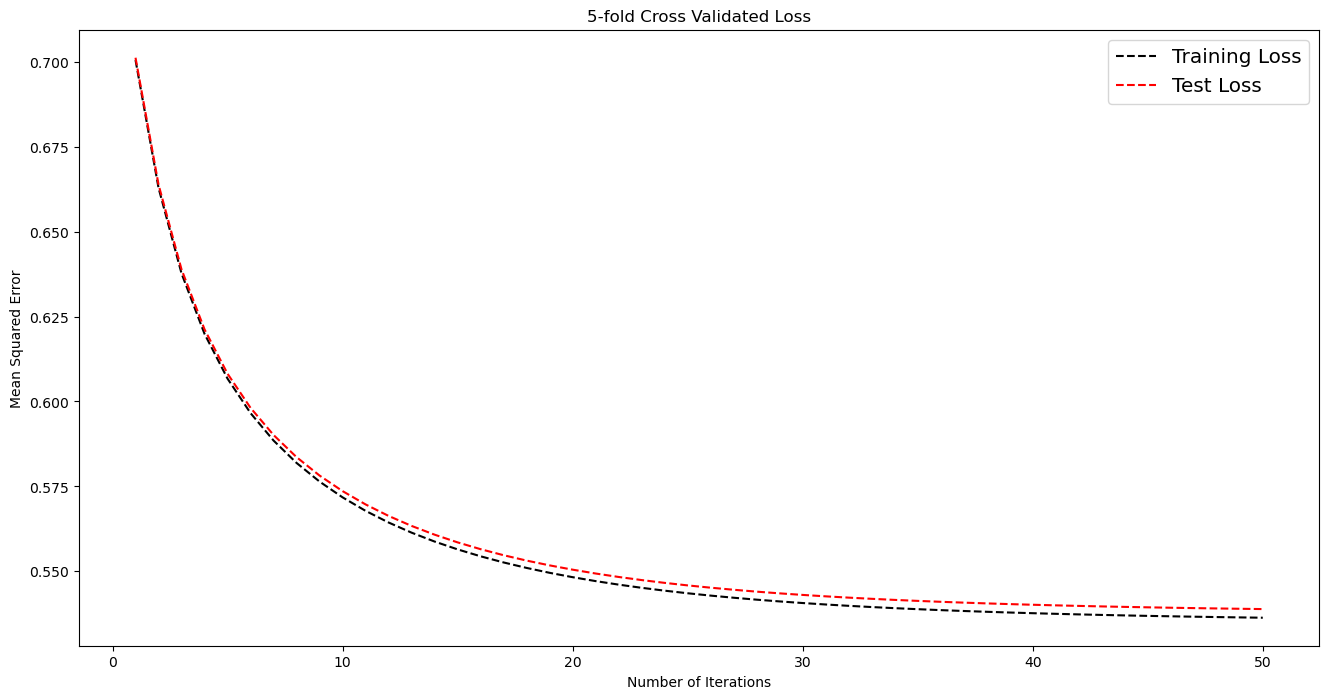

None

In [133]:
# part f - take a look (RUN THIS CELL AS IS)
plotErrorCurves(trainLoss, testLoss, title = '5-fold Cross Validated Loss' )

<b> Question 6F Expected Output <b>


<img src='https://github.com/UCB-w261/w261-environment/blob/master/hw-images/HW4%20Expected%20Outputs/Q6%20Expected%20Output.png?raw=true' style='width:60%'>

# ✅ Question 7: Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are \\(2^{p}\\) potential models that can be built from \\(p\\) features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. In this question you will implement Gradient Descent with ridge and lasso regularization.

__`IMPORTANT NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calculation (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).

### Q7 Tasks:
* __a) Multiple Choce on Digital Campus:__ Identify the formula for the loss function for Ridge Regularization.

* __b) Multiple Choice on Digital Campus:__ Identify the formula for the gradient function for Ridge Regularization.

* __c) Multiple Choice on Digital Campus:__ Identify the formula for the loss function for Lasso Regularization.

* __d) Multiple Choice on Digital Campus:__ Identify the formula for the gradient function for Lasso Regularization.

* __e) Code:__ Fill in the first two missing code blocks in `GDUpdate_wReg()` so that this function will perform a single parameter update using \\(L2\\) regularization if the parameter `regType` is set to `ridge`, \\(L1\\) regularization if set to `lasso` and unregularized OLS otherwise.

* __f) Code + Short Answer on Digital Campus:__ Use the provided code to train 50 iterations of ridge and lasso regression and plot the test/train error. Comment on the curves you see. Does this match your expectation? Explain why or why not.

### Q7 Student Answers:

OPTIONAL - if you'd like to save your answers in this notebook: 

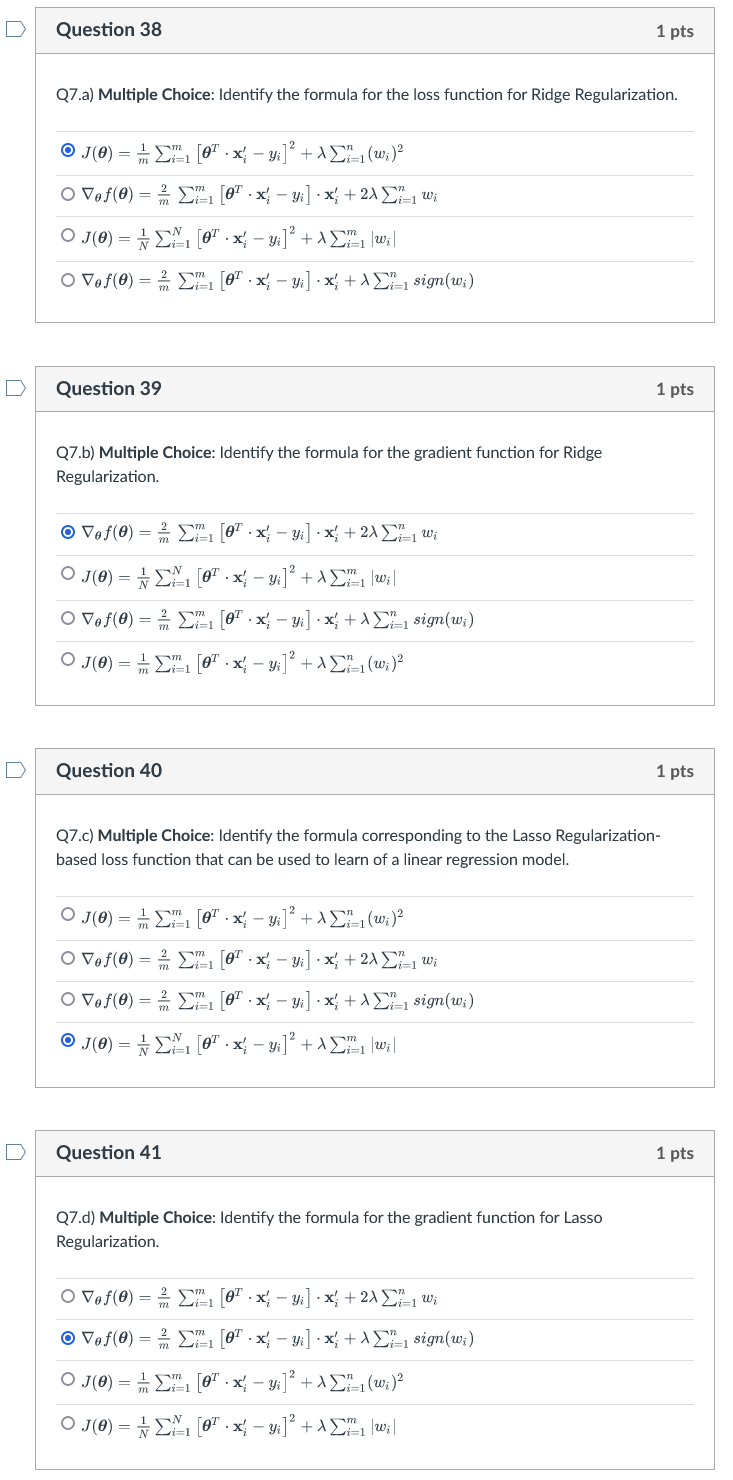

> __f)__ Type your answer here!

In [62]:
# <--- OPTIONAL ---> 
# part e - This code block is for your reference, to check the difference between using np.sign() 
# and the (wReg>0).astype(int) * 2 - 1 output
import numpy as np
W=np.array([1,-2,0,4])
print(2*np.append([0.0], W[1:]))
print(W)

# np.sign() method returns 0 for any record that is 0
wreg=np.sign(W)
wreg[0]=0
print(wreg)

# Using .astype(int) method returns -1 for any record that is 0
wReg = W * 1
wReg=(wReg>0).astype(int) * 2-1
wReg[0] = 0
print(wReg)

[ 0. -4.  0.  8.]
[ 1 -2  0  4]
[ 0 -1  0  1]
[ 0 -1 -1  1]


In [85]:
# part e - gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################

    wBroadcast = sc.broadcast(W)
    if regType == 'lasso':
        wreg = regParam*np.sign(W)
        wreg[0] = 0
        grad = (2*augmentedData.map(lambda d: d[0] * (np.dot(d[0], wBroadcast.value) - d[1])).mean()) + wreg
    elif regType == 'ridge': # ridge
        wreg = 2*regParam*W
        wreg[0] = 0
        grad = augmentedData.map(lambda d: 2* (d[0] * (np.dot(d[0], wBroadcast.value) - d[1]))).mean() + wreg
    else:
        grad = 2*augmentedData.map(lambda d: d[0] * (np.dot(d[0], wBroadcast.value) - d[1])).mean()
    new_model = W - learningRate*grad

    ################## (END) YOUR CODE ####################
    return new_model

In [86]:
# part e - ridge/lasso gradient descent function (RUN THIS CELL AS IS)
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(OLSLoss(trainRDD, model))
        test_history.append(OLSLoss(testRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [87]:
# part f - run 50 iterations of ridge (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50, 
                                     regType='ridge', regParam = 0.05 )
print(f"\n... trained {len(ridge_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 12.50937271118164 seconds


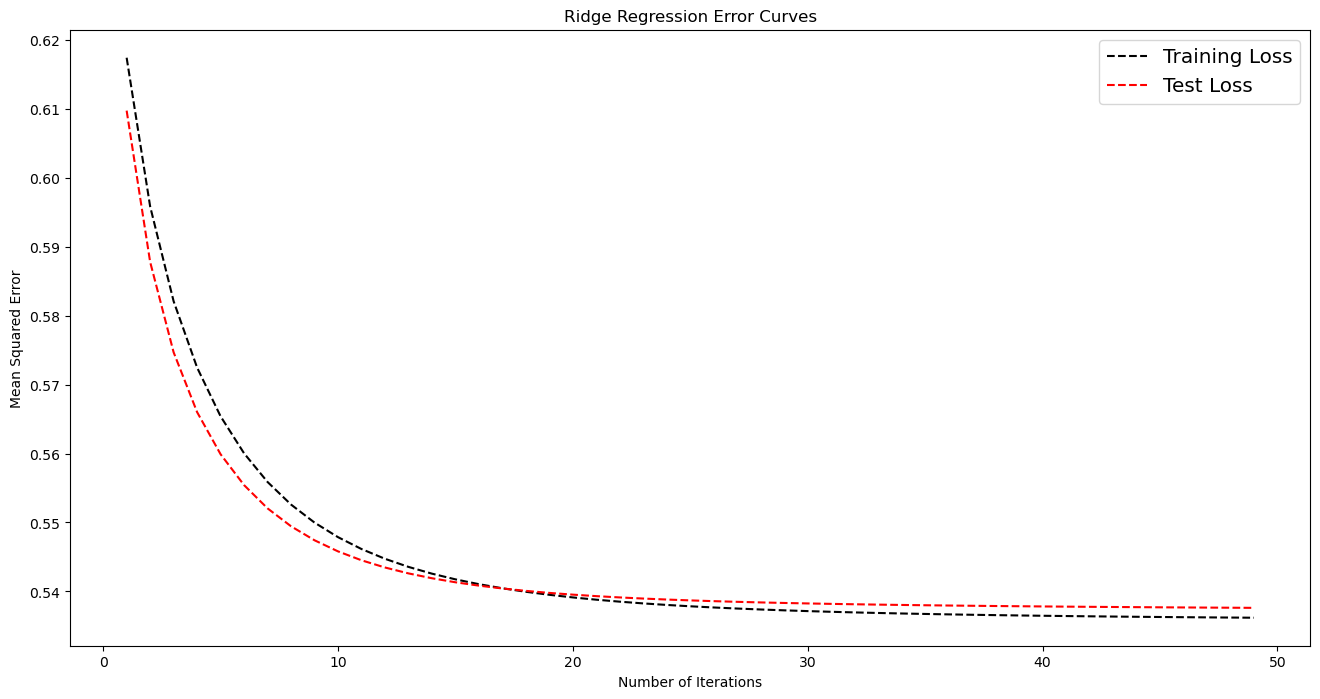

None

In [88]:
# part f - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = ridge_results
np.savetxt('/data/ridge_models.csv', np.array(models), delimiter=',')
np.savetxt('/data/ridge_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )

<b> Question 7F Expected Output <b>


<img src='https://github.com/UCB-w261/w261-environment/blob/master/hw-images/HW4%20Expected%20Outputs/Q7%20Ridge%20Expected%20Output.png?raw=true' style='width:60%'>

In [89]:
# part f - Put data on personal bucket (RUN THIS CELL AS IS)
data_loc = f'{HW4_FOLDER}/data/ridge_models.csv'
!cat data/ridge_models.csv | gsutil cp - {data_loc}
data_loc = f'{HW4_FOLDER}/data/ridge_loss.csv'
!cat data/ridge_loss.csv | gsutil cp - {data_loc}

Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


In [90]:
# part f - run 50 iterations of lasso (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.05)
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 12.288436889648438 seconds


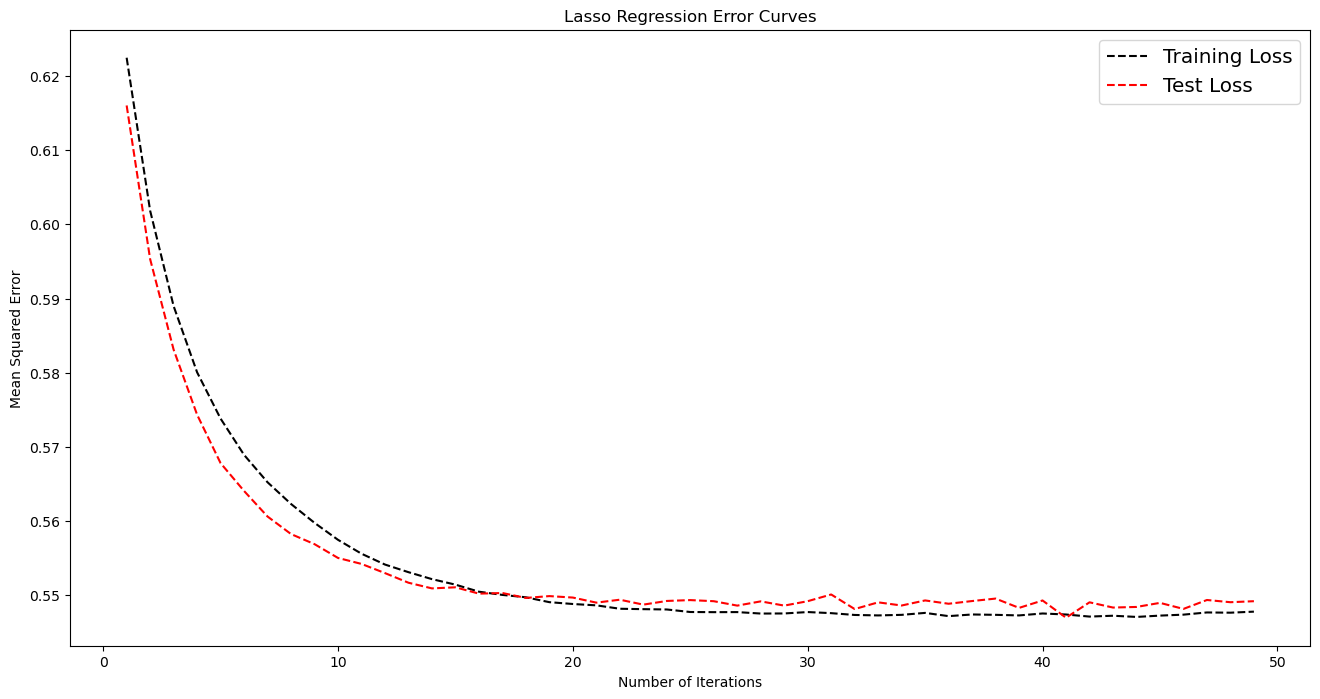

None

In [91]:
# part f - save and display lasso results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = lasso_results
np.savetxt('/data/lasso_models.csv', np.array(models), delimiter=',')
np.savetxt('/data/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

<b> Question 7F Expected Output <b>


<img src='https://github.com/UCB-w261/w261-environment/blob/master/hw-images/HW4%20Expected%20Outputs/Q7%20Lasso%20Expected%20Output.png?raw=true' style='width:60%'>

In [92]:
# part f - Put data on personal bucket (RUN THIS CELL AS IS)
data_loc = f'{HW4_FOLDER}/data/lasso_models.csv'
!cat data/lasso_models.csv | gsutil cp - {data_loc}
data_loc = f'{HW4_FOLDER}/data/lasso_loss.csv'
!cat data/lasso_loss.csv | gsutil cp - {data_loc}

Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


# ✅ Question 8: Results

In this question we'll use a few different plots to help us compare the OLS, Ridge and Lasso models that we have trained. Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method.

### Q8 Tasks:
* __a) Code:__ Use the provided code to load the training history from files and retrieve the best (i.e. last) model from each method. Then create a new RDD called `validationRDD` from the held out data, and compute the mean squared error (MSE) on the new validation dataset for each of the three models (OLS, Ridge and Lasso). You don't need to include the regularization loss in the MSE calculations.

    [__`TIP:`__ _the held out data is in its raw form, don't forget to parse and normalize before applying your calculations, you should also be careful to normalize using the same scaling parameters that you used for the training data._]

* __b) Numeric Answer on Digital Campus:__ Enter the Mean Squared Error for the OLS model (to at least 4 decimal places).

* __c) Numeric Answer on Digital Campus:__ Enter the Mean Squared Error for the Ridge model (to at least 4 decimal places).

* __d) Numeric Answer on Digital Campus:__ Enter the Mean Squared Error for the Lasso model (to at least 4 decimal places).

* __e) Multiple Choice on Digital Campus:__ Which model performed best and what is a valid possible interpretation of these results?

* __f) Multiple Choice on Digital Campus:__ Use the provided code to plot side by side boxplots of the residuals vs. the outcome (i.e. `quality`). What can you observe about our model performance? 
    [__`TIP:`__ _note that the heldout data set is plenty small enough to fit in memory so no need to sample. Feel free to do your plotting in pandas or any other comfortable python package._]

* __g) Multiple Choice on Digital Campus:__ Run the provided code to visualize the model coefficients for the first 50 iterations of training. What do you observe about how the OLS, ridge and lasso coefficients change over the course of the training process?

### Q8 Student Answers:

OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ Type your answer here!  

> __b)__ Type your answer here!  

> __c)__ Type your answer here!

> __d)__ Type your answer here!  

> __e)__ 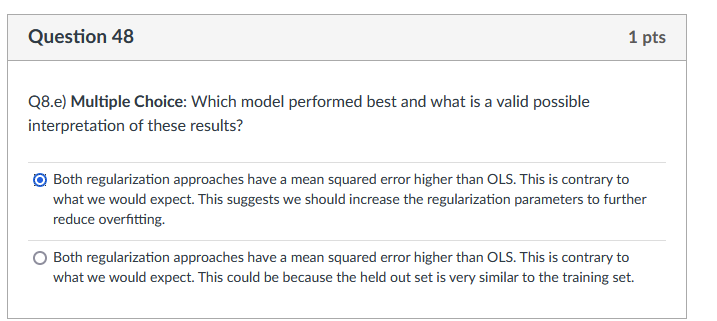

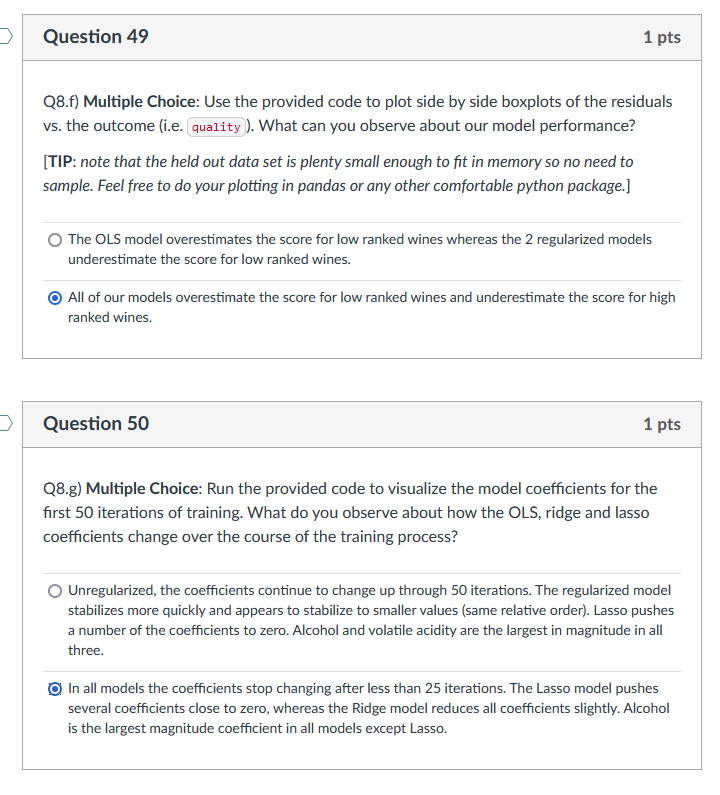

> __f)__ Type your answer here!

> __g)__ Type your answer here!

In [93]:
# part a - load the models from file (RUN THIS CELL AS IS)
data_loc = !gsutil cat {HW4_FOLDER}/data/OLSmodels.csv
ols_models = np.loadtxt(data_loc, dtype=float, delimiter=',')

data_loc = !gsutil cat {HW4_FOLDER}/data/ridge_models.csv
ridge_models = np.loadtxt(data_loc, dtype=float, delimiter=',')

data_loc = !gsutil cat {HW4_FOLDER}/data/lasso_models.csv
lasso_models = np.loadtxt(data_loc, dtype=float, delimiter=',')

best_ols = ols_models[-1,:]
best_ridge = ridge_models[-1,:]
best_lasso = lasso_models[-1,:]

In [111]:
# part a - compute MSE on the held out data for all three 'best' models
olsMSE, ridgeMSE, lassoMSE = None, None, None
validationRDD = None
############### YOUR CODE HERE #################

featureMeans = trainRDDCached.map(lambda x: x[0]).mean()
featureStdev = np.sqrt(trainRDDCached.map(lambda x: x[0]).variance())
validationRDD = heldOutRDD.map(parse).map(lambda x: ( ((x[0] - featureMeans) / featureStdev), x[1]) ).cache()

olsMSE   = OLSLoss(validationRDD, best_ols)
ridgeMSE = OLSLoss(validationRDD, best_ridge)
lassoMSE = OLSLoss(validationRDD, best_lasso)

############### YOUR CODE HERE #################

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

OLS Mean Squared Error: 0.5529543649488734
Ridge Mean Squared Error: 0.5547695952730078
Lasso Mean Squared Error: 0.5624143772925653


In [112]:
# part f - helper function (RUN THIS CELL AS IS)
def get_residuals(dataRDD, model):
    """
    Return a collected list of tuples (residual, quality_score)
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    residuals = augmentedData.map(lambda x: (x[1] - model.dot(x[0]), x[1]))
    return residuals.collect()

In [113]:
# part f - compute residuals for all three models (RUN THIS CELL AS IS)
ols_resid = np.array(get_residuals(validationRDD, best_ols))
ridge_resid = np.array(get_residuals(validationRDD, best_ridge))
lasso_resid = np.array(get_residuals(validationRDD, best_lasso))

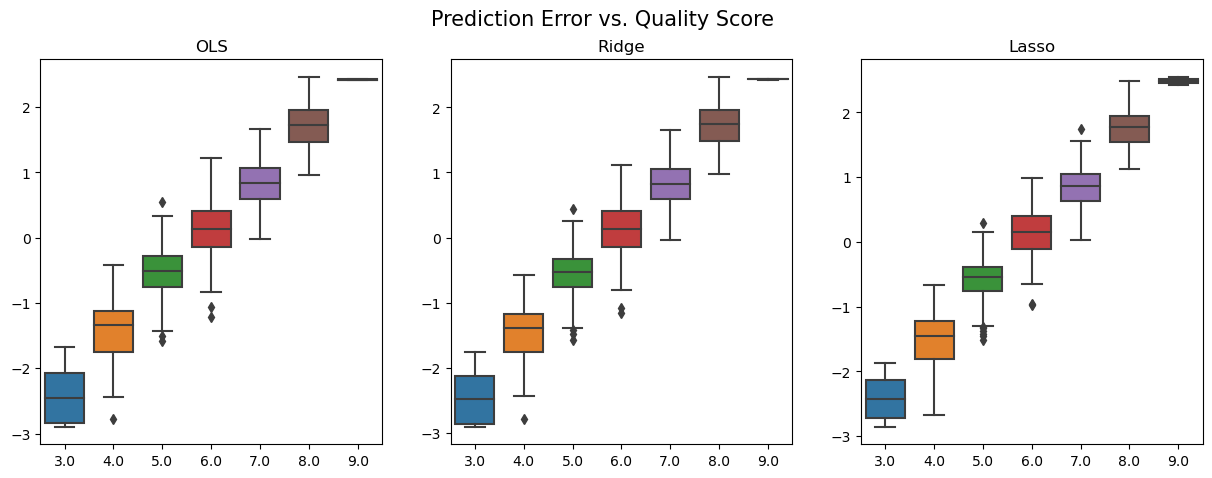

None

In [114]:
# part f - boxplots of residuals for all three models (RUN THIS CELL AS IS)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
stuff_to_plot = zip(axes, ["OLS", "Ridge", "Lasso"], [ols_resid, ridge_resid, lasso_resid])
for ax, title, data in stuff_to_plot:
    ax.set_title(title)
    y = data[:, 0]
    x = data[:, 1]
    sns.boxplot(x=x, y=y, ax=ax)
fig.suptitle("Prediction Error vs. Quality Score", fontsize=15, y=0.98)
display(plt.show())

In [115]:
# part g - plotting function (RUN THIS CELL AS IS)
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    display(plt.show())

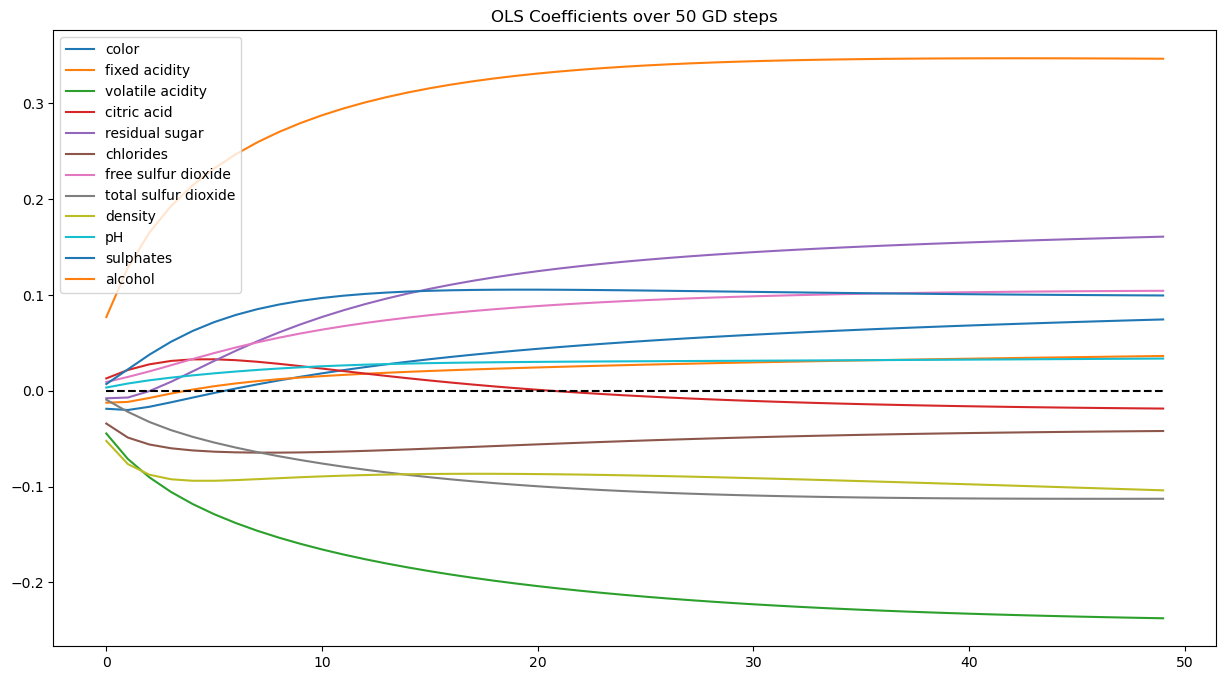

None

In [116]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

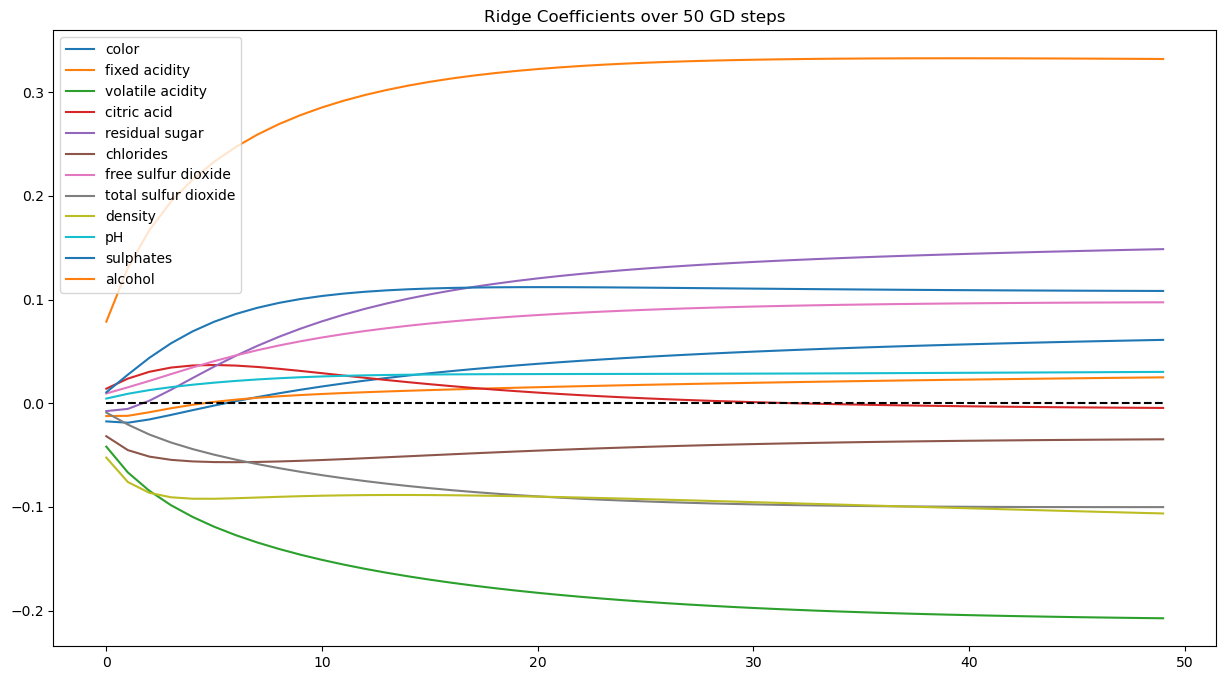

None

In [117]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

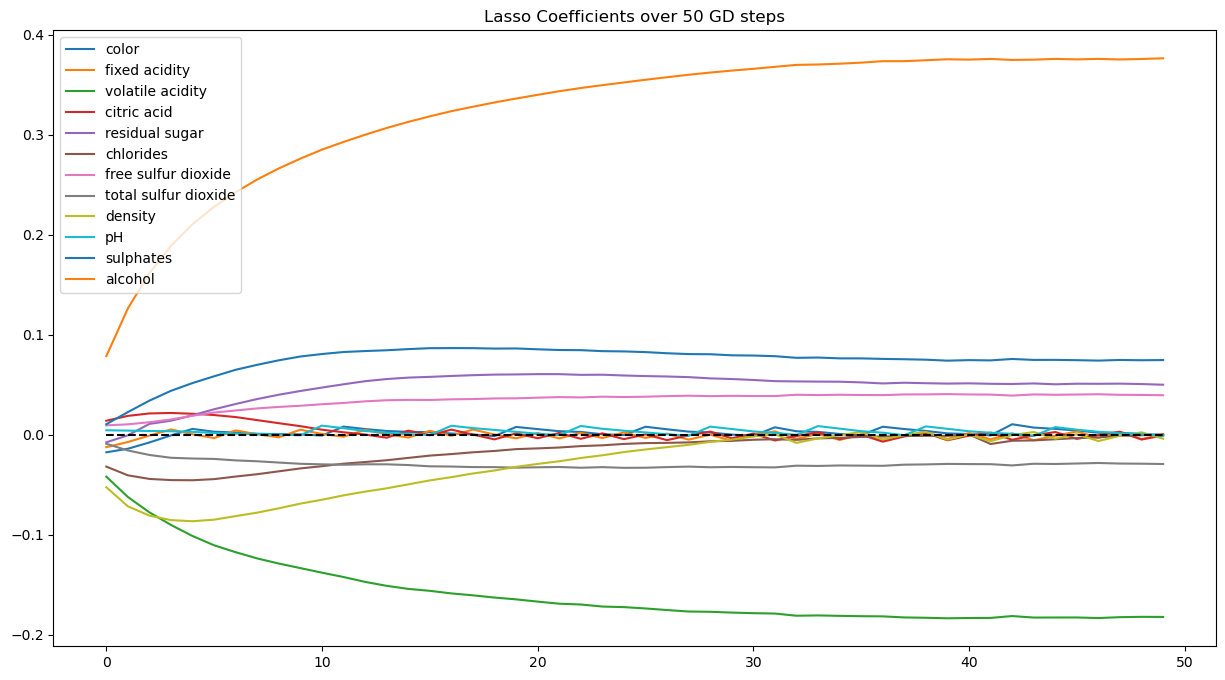

None

In [118]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

# Question 9: DataFrames and MLlib

In this final question we'll confirm our results using DataFrames and the MLlib library, that you will use for your final Project. You can find the documentation [here](https://spark.apache.org/docs/3.1.3/api/python/reference/index.html).

### Q9 Tasks:
* __a1) Code:__ Transform the un-normalized RDD `trainRDDCached` from the section *Load data and do EDA* into a Spark Dataframe. Then display the top 10 rows of the Spark Dataframe as a Pandas Dataframe.
* __a2) Numeric Answer on Digital Campus:__ What is the pH of the first wine (the wine at index 0) in the dataframe you've just created (to at least 2 decimal places)?


* __b1) Code:__ Normalize the Spark Dataframe and show us the top 10 rows. You *don't* need to display the dataframe as a pandas dataframe here.
* __b2) Numeric Answer On Digital Campus:__ What is the first normalized (scaled) feature value for the first wine in the dataframe (to at least 4 decimal places)?


* __c1) Code:__ Build a Linear Regression Model using `pyspark.ml.regression` and train for 50 iterations. (Hint: set maxIter=50])
* __c2) Numeric Answer On Digital Campus:__ What is the MSE for the Linear Regression Model you just wrote (to at least 4 decimal places)?


* __d1) code:__ Build a Lasso and Ridge Model using `pyspark.ml.regression` and train for 50 iterations.
    
    [`Hint`: _use following parameters when you call LinearRegression_]
    
    ```
    ridge = LinearRegression(featuresCol = '<name_of_featuresCol>', labelCol='<name_of_labelCol>', maxIter=50, regParam = 0.1, elasticNetParam = reg_par[0])

    lasso = LinearRegression(featuresCol = '<name_of_featuresCol>', labelCol='<name_of_labelCol>', maxIter=50, regParam = 0.1, elasticNetParam = reg_par[1])
    ```
    <br>
* __d2) Numeric Answer On Digital Campus:__ What is the MSE for the Linear Regression Model with __Lasso__ regularization you just wrote (to at least 4 decimal places)?


* __e1) Code:__ Evaluate your models with the held-out test set for the basic Linear Regression, Lasso and Ridge models.
* __e2) Multiple Choice On Digital Campus:__ Given the choices of basic linear regression, linear regression with Lasso regularization, and linear regression with Ridge regularization, which model did the best?

### Q9 Student Answers:

OPTIONAL - if you'd like to save your answers in this notebook: 

> __a2)__ Type your answer here!  

> __b2)__ Type your answer here!  

> __c2)__ Type your answer here!

> __d2)__ Type your answer here!  

> __e2)__ Type your answer here!  


In [55]:
# Part a - From RDD to DataFrame
columns = ["wine type", "fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality"]
############### YOUR CODE HERE #################

trainDF = spark.createDataFrame(trainRDDCached.map(lambda x: tuple([float(x) for x in x[0].tolist() + [x[1]]] )), schema=columns)



############### YOUR CODE HERE #################
trainDF.limit(10).toPandas()

,wine type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,1.0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
2,1.0,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
3,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
4,1.0,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5.0
5,1.0,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5.0
6,1.0,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7.0
7,1.0,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5.0
8,1.0,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5.0
9,1.0,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5.0


In [57]:
# Part b - Normalize DF
# We first need to create a Vector Assembler to create the feature space that will be fed to ML models
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
trainDF_VA = assembler.transform(trainDF)

############### YOUR CODE HERE #################
scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(trainDF_VA)

# Normalize each feature to have unit standard deviation.
trainDF_VA = scalerModel.transform(trainDF_VA)

############### YOUR CODE HERE #################
trainDF_VA.limit(10).toPandas()

,wine type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,features,features_scaled
0,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978...","[0.15182441253819356, 2.160436857764478, -2.17..."
1,1.0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0,"[7.8, 0.76, 0.04, 2.3, 0.092, 15.0, 54.0, 0.99...","[0.46385982935194986, 2.5214222142811535, -1.9..."
2,1.0,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0,"[11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.9...","[3.1161608722688814, -0.3664606378522484, 1.66..."
3,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978...","[0.15182441253819356, 2.160436857764478, -2.17..."
4,1.0,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5.0,"[7.4, 0.66, 0.0, 1.8, 0.075, 13.0, 40.0, 0.997...","[0.15182441253819356, 1.9197799534200282, -2.1..."
5,1.0,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5.0,"[7.9, 0.6, 0.06, 1.6, 0.069, 15.0, 59.0, 0.996...","[0.5418686835553894, 1.5587945969033525, -1.76..."
6,1.0,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7.0,"[7.8, 0.58, 0.02, 2.0, 0.073, 9.0, 18.0, 0.996...","[0.46385982935194986, 1.4384661447311275, -2.0..."
7,1.0,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5.0,"[7.5, 0.5, 0.36, 6.1, 0.071, 17.0, 102.0, 0.99...","[0.22983326674163246, 0.9571523360422274, 0.29..."
8,1.0,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5.0,"[6.7, 0.58, 0.08, 1.8, 0.097, 15.0, 65.0, 0.99...","[-0.39423756688588074, 1.4384661447311275, -1...."
9,1.0,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5.0,"[7.5, 0.5, 0.36, 6.1, 0.071, 17.0, 102.0, 0.99...","[0.22983326674163246, 0.9571523360422274, 0.29..."


In [88]:
# Part c - Train Linear Regression Model
from pyspark.ml.regression import LinearRegression
trainDF_VA = trainDF_VA.select(['features_scaled', 'quality'])

############### YOUR CODE HERE #################
lr = LinearRegression(featuresCol = 'features_scaled', labelCol = 'quality', maxIter=50)
lr_model = lr.fit(trainDF_VA)
trainingSummary = lr_model.summary
############### YOUR CODE HERE #################

23/07/06 04:18:04 WARN org.apache.spark.ml.util.Instrumentation: [87cf40ee] regParam is zero, which might cause numerical instability and overfitting.


In [89]:
# Part c - (RUN THIS CELL AS IS)
print("Coefficients: " + str(np.round(lr_model.coefficients, 4)))
print("Intercept: " + str(round(lr_model.intercept, 4)))
print("MSE: %f" % trainingSummary.rootMeanSquaredError**2)
print("r2: %f" % trainingSummary.r2)

Coefficients: [ 0.0718 -0.2091 -0.0185  0.1992 -0.0281  0.1101 -0.1506 -0.1567  0.0599
  0.1213  0.3199]
Intercept: 5.811
MSE: 0.536682
r2: 0.293919


In [65]:
# Part d - LASSO and Ridge
reg_par = [0, 1] # 0 Corresponds to Ridge, 1 correspond to LASSO
############### YOUR CODE HERE #################
## Ridge
ridge = LinearRegression(featuresCol = 'features_scaled', labelCol='quality', maxIter=50, regParam = 0.1, elasticNetParam = reg_par[0])
ridge_model = ridge.fit(trainDF_VA)
RidgeSummary = ridge_model.summary

## LASSO
lasso = LinearRegression(featuresCol = 'features_scaled', labelCol='quality', maxIter=50, regParam = 0.1, elasticNetParam = reg_par[1])
lasso_model = lasso.fit(trainDF_VA)
LassoSummary = lasso_model.summary
############### YOUR CODE HERE #################

In [66]:
# Part d - (RUN THIS CELL AS IS)
print("Ridge Model:")
print("\t Coefficients: " + str(np.round(ridge_model.coefficients, 4)))
print("\t Intercept: " + str(round(ridge_model.intercept, 4)))
print("\t MSE: %f" % RidgeSummary.rootMeanSquaredError**2)
print("\t r2: %f" % RidgeSummary.r2)
print("\n")
print("LASSO Model:")
print("\t Coefficients: " + str(np.round(lasso_model.coefficients, 4)))
print("\t Intercept: " + str(round(lasso_model.intercept, 4)))
print("\t MSE: %f" % LassoSummary.rootMeanSquaredError**2)
print("\t r2: %f" % LassoSummary.r2)
print("\n")

Ridge Model:
	 Coefficients: [ 0.0267 -0.1803  0.0005  0.1192 -0.0434  0.0814 -0.1072 -0.0917  0.0331
  0.1027  0.3038]
	 Intercept: 5.811
	 MSE: 0.540799
	 r2: 0.288504


LASSO Model:
	 Coefficients: [ 0.     -0.1131  0.      0.      0.      0.      0.      0.      0.
  0.      0.2871]
	 Intercept: 5.811
	 MSE: 0.582095
	 r2: 0.234173




In [84]:
# Part e - Evaluate Held Out Set

# Create Held Out DataFrame
############### YOUR CODE HERE #################
heldOutCachedRDD = heldOutRDD.map(parse).map(lambda x: tuple([float(x) for x in x[0].tolist() + [x[1]]] )).cache()
heldOutDF = spark.createDataFrame(heldOutCachedRDD, schema=columns)

############### YOUR CODE HERE #################


# Apply VectorAssembler and Normalize Held Out
############### YOUR CODE HERE #################
assembler = VectorAssembler(inputCols=features, outputCol="features")
heldOutDF_VA = assembler.transform(heldOutDF)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(heldOutDF_VA)

# Normalize each feature to have unit standard deviation.
heldOutDF_VA = scalerModel.transform(heldOutDF_VA).cache()
heldOutDF_VA = heldOutDF_VA.select(['features_scaled', 'quality'])
############### YOUR CODE HERE #################



In [90]:
# Predict and Evaluate Performance
############### YOUR CODE HERE #################
# Predictions
lr_predictions    = lr_model.predict(heldOutDF_VA.features_scaled)
ridge_predictions = ridge_model.predict(heldOutDF_VA.features_scaled)
lasso_predictions = lasso_model.predict(heldOutDF_VA.features_scaled)

# MSE
lr_mse = lr_model.loss
ridge_mse = ridge_model.loss
lasso_mse = lasso_model.loss

############### YOUR CODE HERE #################

TypeError: cannot pickle '_thread.RLock' object

In [ ]:
# Part e - (RUN THIS CELL AS IS)
print("Linear Regression Model:")
print(f"\t MSE: {lr_mse}")
print("\n")
print("Ridge Model:")
print(f"\t MSE: {ridge_mse}")
print("\n")
print("LASSO Model:")
print(f"\t MSE: {lasso_mse}")
print("\n")

### Congratulations, you have completed HW4!

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform